# NLTK Chapter 2

## Accessing Text Corpora and Lexical Resources

*The html version of this chapter in the NLTK book is available [here](https://www.nltk.org/book/ch02.html#exercises "Ch02 Exercises").*

### 8   Exercises

###### 1. 

☼ Create a variable `phrase` containing a list of words. Review the operations described in the previous chapter, including addition, multiplication, indexing, slicing, and sorting..

In [1]:
phrase1 = ['This', 'is', 'a', 'lovely', 'list', 'of', 'words.']
phrase2 = ['As', 'is', 'this.']

phrase1 + phrase2

['This', 'is', 'a', 'lovely', 'list', 'of', 'words.', 'As', 'is', 'this.']

In [2]:
print(phrase1 * 3, end = '')

['This', 'is', 'a', 'lovely', 'list', 'of', 'words.', 'This', 'is', 'a', 'lovely', 'list', 'of', 'words.', 'This', 'is', 'a', 'lovely', 'list', 'of', 'words.']

In [3]:
phrase1[-1]

'words.'

In [4]:
phrase1[2:]

['a', 'lovely', 'list', 'of', 'words.']

In [5]:
sorted(phrase1 + phrase2)

['As', 'This', 'a', 'is', 'is', 'list', 'lovely', 'of', 'this.', 'words.']

###### 2.

☼ Use the corpus module to explore `austen-persuasion.txt`. How many word tokens does this book have? How many word types?

*As I discussed at length in my notes, I recommend removing non-alphabetic characters and enclitics:*

In [6]:
from nltk.corpus import gutenberg

austen = 'austen-persuasion.txt'
enclitics = ("d", "ll", "m", "re", "s", "t", "ve")
words = gutenberg.words(austen)

# number of tokens
num_tokens = len([w for w in words if w.isalpha() and w not in enclitics])

num_tokens

83617

In [7]:
# number of word types
num_wt = len(set([w for w in words if w.isalpha() and w not in enclitics]))
num_wt

6031

*If we didn't bother with removing non-alphabetic characters and enclitics:*

In [8]:
# number of tokens
num_tokens = len([w for w in words])

num_tokens

98171

In [9]:
# number of word types
num_wt = len(set([w for w in words]))
num_wt

6132

###### 3. 

☼ Use the Brown corpus reader `nltk.corpus.brown.words()` or the Web text corpus reader `nltk.corpus.webtext.words()` to access some sample text in two different genres.

*The code below will randomly choose a category, and then randomly print five sentences from that category.*

In [10]:
from nltk.corpus import brown
import random

random_category = random.choice(brown.categories())
random_place = random.randint(0, len(brown.sents(categories = random_category)) - 5)

text = brown.sents(categories = random_category)[random_place:random_place + 5]

print(text, end = '')

[['Reply', ':'], ['A', 'back', 'brace', 'might', 'help', ',', 'depending', 'upon', 'the', 'cause', 'of', 'sciatica', '.'], ['Cholesterol', 'and', 'thyroid'], ['writes', ':', 'Does', 'the', 'cholesterol', 'go', 'down', 'when', 'most', 'of', 'the', 'thyroid', 'gland', 'is', 'removed', '?', '?'], ['Reply', ':']]

*As you can see, the output doesn't look very nice.  We could try a list comprehension:*

In [11]:
print([w for w in text], end = '')

[['Reply', ':'], ['A', 'back', 'brace', 'might', 'help', ',', 'depending', 'upon', 'the', 'cause', 'of', 'sciatica', '.'], ['Cholesterol', 'and', 'thyroid'], ['writes', ':', 'Does', 'the', 'cholesterol', 'go', 'down', 'when', 'most', 'of', 'the', 'thyroid', 'gland', 'is', 'removed', '?', '?'], ['Reply', ':']]

*After much trial and error, I came to the conclusion that the best way to format tokenized text in a list is to attach the punctuation to its preceding string.  I came across a function at [this Stack Overflow discussion](https://stackoverflow.com/questions/15950672/join-split-words-and-punctuation-with-punctuation-in-the-right-place#answers "join_punctuation") that did exactly this.  I made slight changes to deal with the idiosyncracies of the sentences in the Brown Corpus:*

In [12]:
def join_punctuation(text, characters = ["'", ')', ',', '.', ':', ';', '?', '!', ']', "''"]): 
    """
    Takes a list of strings and attaches punctuation to
    the preceding string in the list.
    """
    
    text = iter(text)
    current = next(text)

    for nxt in text:
        if nxt in characters:
            current += nxt
        else:
            yield current
            current = nxt
            

    yield current

*The above function only works when the punctuation follows a string.  I needed to create a second function for those cases when the punctuation precedes a string.  Due to the pecularities of Python's `iter`, the below function will work for two successive punctuation marks in a row, but not more - however, the above function will work for an unlimited number of successive punctuation marks.*

In [13]:
def join_brackets(text, characters = ['``', '(', '[']):
    """
    Takes a list of strings and attaches punctuation to
    the following string in the list. The maximum number of
    successive punctuation marks is two.
    """    
    text = iter(text)
            
    for s in text:
        if s in characters:
            yield s + next(text, '')
        else:
            yield s

*There's another pecularity of the Brown Corpus that we have to deal with: for reasons I'm not aware of, many punctuation marks are duplicated.  This next function gets rid of that:*

In [14]:
def remove_duplicate_punctuation(text):
    seq = iter(text)
    current = next(seq)
    
    for nxt in seq:
        if nxt == current:
            pass
        else:
            yield current
            current = nxt
            
    yield current

*There's a final issue with single quotes: In the Brown Corpus, there is a clear distinction between opening and closing double quotes ('``' vs. "''"), so it's clear whether the quotes should be attached to the preceding or following word. But single quotes lack this distinction, and at the moment they're always being attached to the previous word. This final function will switch the positions of "'" and " " on odd-numbered occurrences, but not on even-numbered occurrences.  I.e., if a single quote begins and ends within our sample, the quotes should be in the right positions.*

In [15]:
def switch_quotes(text):
    """
    Switches positions of single quotes and spaces on odd-numbered
    occurrences.  Fixes an idiosyncracy that arises when formatting
    text from the Brown Corpus.
    """
    temp = list(text)
    flag = False
    for t in range(len(temp)):
        if temp[t] == "'" and temp[t + 1] == " ":
            
            # ignore two single quotes used as a double quote
            if temp[t - 1] == "'":
                pass
            elif flag == False:
                temp[t], temp[t + 1] = temp[t + 1], temp[t]
                flag = True
            else:
                flag = False
            
    return ''.join(temp)

*Finally, we'll encase everything in one function that will call the four functions above:*

In [16]:
def clean_brown(text):
    full_text = []
    for t in text:
        full_text.append(' '.join(join_brackets(join_punctuation(remove_duplicate_punctuation(t)))))
    return switch_quotes(' '.join(full_text))

In [17]:
clean_brown(text)

'Reply: A back brace might help, depending upon the cause of sciatica. Cholesterol and thyroid writes: Does the cholesterol go down when most of the thyroid gland is removed? Reply:'

*This looks much better than it did.  Let's try it again with another random text:*

In [18]:
random_category = random.choice(brown.categories())
random_place = random.randint(0, len(brown.sents(categories = random_category)) - 5)

text = [w for w in brown.sents(categories = random_category)[random_place:random_place + 5]]

clean_brown(text)

"The joint investigations of linguistics and psychiatry have established, in point of fact, that no matter what the subject of conversation is or what words are involved, it is impossible for people to talk at all without telling over and over again what sort of people they are and how they relate to the rest of the world. Since interviewing is the basic therapeutic and diagnostic instrument of modern psychiatry, the recording of interviews for playbacks and study has been a boost of Redstone proportions in new research and training. Some of the earliest recordings, made in the 1940's demonstrated that psychiatrists reacted immediately to anger and anxiety in the sound track, whereas written records of the same interview offered far fewer cues to therapy which -- if they were at all discernible in print -- were picked up only by the most skilled and sensitive experts. In a general way, psychiatrists were able to establish on a wide basis what many of them had always felt -- that the mo

###### 4.
☼ Read in the texts of the State of the Union addresses, using the `state_union` corpus reader. Count occurrences of `men`, `women`, and `people` in each document. What has happened to the usage of these words over time?

In [19]:
import nltk
%matplotlib inline
from nltk.corpus import state_union

In [20]:
cfd = nltk.ConditionalFreqDist(
        (target, fileid[:4])
        for fileid in state_union.fileids()
        for w in state_union.words(fileid)
        for target in ['men', 'women', 'people']
        if w.lower().startswith(target))

*There are too many documents here for us to put them in a table that will fit across the screen:*

In [21]:

len(state_union.fileids())

65

*One option to deal with this is to use a sampling of one State of the Union from every four years.  This way, there will be approximately one address for each presidential term:*

In [22]:
years = range(1945, 2007, 4)
cfd.tabulate(samples = [str(y) for y in years], conditions = ['men', 'women', 'people'])

       1945 1949 1953 1957 1961 1965 1969 1973 1977 1981 1985 1989 1993 1997 2001 2005 
   men    2    2    5    7    6   22    5    1    2    3    1    4    1    1    6    8 
 women    2    1    0    2    0    3    2    0    1    1    1    3    2    2    6   11 
people   10   18   20   17   13   30    6   10   20   11   12   13   45   31   27   18 


*Another option is to use a plot instead of a table:*

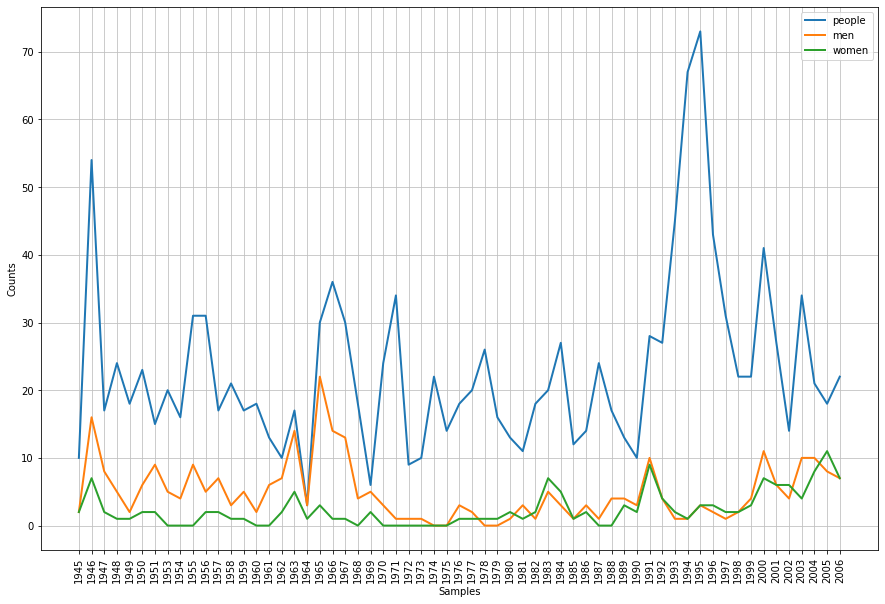

In [23]:
# to adjust the size of the plot
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
cfd.plot();

###### 5.

☼ Investigate the holonym-meronym relations for some nouns. Remember that there are three kinds of holonym-meronym relation, so you need to use: `member_meronyms()`, `part_meronyms()`, `substance_meronyms()`, `member_holonyms()`, `part_holonyms()`, and `substance_holonyms()`.

*As I mentioned in my notes for Chapter 2, I've found WordNet to be quite difficult to navigate.  The work that I've done on this unit has done nothing to convince me otherwise.  In addition to being difficult to use, I'm finding WordNet rather incomplete.  Let me take 'school' as an example.  Since I'm not sure which synset corresponds to the traditional meaning of 'school', I'll look up the definitions.*

In [24]:
from nltk.corpus import wordnet as wn

In [25]:
[s.definition() for s in wn.synsets('school')]

['an educational institution',
 'a building where young people receive education',
 'the process of being formally educated at a school',
 'a body of creative artists or writers or thinkers linked by a similar style or by similar teachers',
 'the period of instruction in a school; the time period when school is in session',
 "an educational institution's faculty and students",
 'a large group of fish',
 'educate in or as if in a school',
 'teach or refine to be discriminative in taste or judgment',
 'swim in or form a large group of fish']

In [26]:
wn.synset('school.n.01').member_meronyms()

[Synset('schoolteacher.n.01'), Synset('staff.n.03')]

*Of course, a school needs teachers, as well as staff.  But doesn't it seem odd that it's lacking students?  Let's try another example: 'team'.*

In [27]:
[s.definition() for s in wn.synsets('team')]

['a cooperative unit (especially in sports)',
 'two or more draft animals that work together to pull something',
 'form a team']

In [28]:
wn.synset('team.n.01').member_meronyms()

[Synset('stringer.n.01')]

*So, "stringer"s are more essential to teams than players?  Interesting...*

In [29]:
wn.synset('team.n.01').part_meronyms()

[Synset('bench.n.06')]

In [30]:
wn.synset('school.n.02').part_meronyms()

[Synset('classroom.n.01')]

*I'm not too surprised that 'school's and 'team's don't have substances, but it was rather difficult to come up with non-chemical examples.*

In [31]:
wn.synset('water.n.01').substance_meronyms()

[Synset('hydrogen.n.01'), Synset('oxygen.n.01')]

*Blood is made from serum?  Fascinating...*

In [32]:
wn.synset('blood.n.01').substance_meronyms()

[Synset('serum.n.01')]

*Let's go the other way and see if we have more luck:*

In [33]:
[s.definition() for s in wn.synsets('player')]

['a person who participates in or is skilled at some game',
 'someone who plays a musical instrument (as a profession)',
 'a theatrical performer',
 'a person who pursues a number of different social and sexual partners simultaneously',
 'an important participant (as in a business deal)']

In [34]:
wn.synset('player.n.01').member_holonyms()

[]

In [35]:
wn.synset('player.n.01').part_holonyms()

[]

*Interesting - let's see if `member` is a member of any holonyms:*

In [36]:
[s.definition() for s in wn.synsets('member')]

['one of the persons who compose a social group (especially individuals who have joined and participate in a group organization)',
 'anything that belongs to a set or class',
 'an external body part that projects from the body',
 'an organization that is a member of another organization (especially a state that belongs to a group of nations)',
 "the male organ of copulation (`member' is a euphemism)"]

In [37]:
wn.synset('member.n.01').member_holonyms()

[]

In [38]:
wn.synset('member.n.01').part_holonyms()

[]

*Amazing.  The maintainers of WordNet found it necessary to remark that 'member' can be slang for a penis, but not that 'member' can be, well, a member of anything.*

*Let's keep on trying.  After about five tries, I finally found a word that had a `part_holonym`:*

In [39]:
wn.synset('wing.n.01').part_holonyms()

[Synset('angel.n.01'),
 Synset('bat.n.01'),
 Synset('bird.n.01'),
 Synset('insect.n.01')]

*Likewise, I needed about five tries to find a word that had a `member_holonym`:*

In [40]:
wn.synset('animal.n.01').member_holonyms()

[Synset('animalia.n.01')]

In [41]:
wn.synset('bird.n.01').member_holonyms()

[Synset('aves.n.01'), Synset('flock.n.02')]

*But it was easier to find a __substance holonym__ than __substance meronym__.*

In [42]:
wn.synset('water.n.01').substance_holonyms()

[Synset('body_of_water.n.01'),
 Synset('ice.n.01'),
 Synset('ice_crystal.n.01'),
 Synset('perspiration.n.01'),
 Synset('snowflake.n.01'),
 Synset('tear.n.01')]

*My feelings from earlier are if anything stronger than before: WordNet is too incomplete and too inconsistent to be of any practical use.*

###### 6.

☼ In the discussion of comparative wordlists, we created an object called `translate` which you could look up using words in both German and Spanish in order to get corresponding words in English. What problem might arise with this approach? Can you suggest a way to avoid this problem?

*One issue might be homographs with different meanings.  I.e., a word that is spelled the same in both languages, but has different meanings.  A possible fix would be to add a second parameter to `translate` which would specify from which dictionary the translation should be drawn.*

###### 7. 

☼ According to Strunk and White's Elements of Style, the word however, used at the start of a sentence, means "in whatever way" or "to whatever extent", and not "nevertheless". They give this example of correct usage: <i>[However you advise him, he will probably do as he thinks best.]( http://www.bartleby.com/141/strunk3.html "'However' example")</i> Use the concordance tool to study actual usage of this word in the various texts we have been considering. See also [the LanguageLog posting "Fossilized prejudices about 'however'"](http://itre.cis.upenn.edu/~myl/languagelog/archives/001913.html "Fossilized prejudices about 'however'").

*One issue with NLTK's concordance tool is that it doesn't allow us to specify where in the sentence the word should be found.  In the first 25 occurences of 'however' in "Emma", only three occur at the start of a sentence:*

In [43]:
emma = nltk.Text(nltk.corpus.gutenberg.words('austen-emma.txt'))
emma.concordance("However")

Displaying 25 of 131 matches:
 her many enjoyments . The danger , however , was at present so unperceived , t
ion would offend . Miss Churchill , however , being of age , and with the full 
n . From the expense of the child , however , he was soon relieved . The boy ha
 -- and been very well brought up . However , I do not mean to set up my opinio
f and predict . It was not likely , however , that any body should have equalle
to be borne . We will not despair , however . Weston may grow cross from the wa
is so very handsome and agreeable . However , I do really think Mr . Martin a v
 accepted after all . This letter , however , was written , and sealed , and se
e him ." " And if I did , ( which , however , I am far from allowing ) I should
 slightingly . Waiving that point , however , and supposing her to be , as you 
e was not so materially cast down , however , but that a little time and the re
ld inspire him ." The very next day however produced some proof of inspiration 
and staid 

*To remedy this, I wrote this code, which prints out concordances only if a given word occurs at a specific point in a sentence:*

In [44]:
def find_concordance_by_position(text, word, pos = 0):
    """
    Returns a concordance for a text only if the word is
    found at the given position.  Works on lists where each
    item is a separate sentence.
    
    Arguments:
    
    text: The text to be searched.  Must be a list where
          each item is a separate sentence.
    word: The word to be searched for.  Case insensitive.
    pos:  The position where the word should be found.  
          Default is 0.
    """
    hits = 0
    
    for i in range(len(text)):
        if text[i][pos].lower() == word:
            prefix = text[i - 1]
            prefix = ' '.join(prefix)
            if len(prefix) < 35:
                prefix = (35 - len(prefix)) * " " + prefix
            suffix = text[i]
            suffix = ' '.join(suffix)
            print(prefix[-35:] + " " + suffix[:40])
            hits += 1
            
    if hits == 0:
        print("No matches.")

In [45]:
find_concordance_by_position(nltk.corpus.gutenberg.sents('austen-emma.txt'), "however", 0)

 -- and been very well brought up . However , I do not mean to set up my opi
is so very handsome and agreeable . However , I do really think Mr . Martin 
eed !-- and my memory is very bad . However , it was an exceeding good , pre
          Jane speaks so distinct ! However , she will not find her grandmam
inctly , and was sadly alarmed at . However , when I read on , I found it wa
hough she speaks rather too quick . However , she is very agreeable , and Mr
at I would not expose any body to . However , as they are so very desirous t
ar , I did say as much as I could . However , the very same evening William 
m often astonished at what I hear . However , this does make a difference ; 
aks like you and poor Miss Taylor . However , she seems a very obliging , pr
emed very much to have enjoyed it . However , _I_ shall always think it a ve
t least , but I might be mistaken . However , I think it answered so far as 


*Older texts seem to use the word very infrequently, if at all:*

In [46]:
find_concordance_by_position(nltk.corpus.gutenberg.sents('milton-paradise.txt'), 'however', 0)

f scorn , not to be given the Foe . However I with thee have fixed my lot , 
pride , and joy , for Man seduced . However , some tradition they dispersed 


In [47]:
find_concordance_by_position(nltk.corpus.gutenberg.sents('bible-kjv.txt'), 'however', 0)


No matches.


In [48]:
find_concordance_by_position(nltk.corpus.gutenberg.sents('shakespeare-hamlet.txt'), 'however', 0)


No matches.


*Now I'm going to look at the Brown Corpus, category by category;*

In [49]:
from nltk.corpus import brown

for c in brown.categories():
    print("Now analyzing {}: \n".format(c))

    find_concordance_by_position(brown.sents(categories = c), 'however', 0)
    
    print("\n")


Now analyzing adventure: 

ything but swarms of bees in them . However , when there's a job to be done 


Now analyzing belles_lettres: 

til well into the present century . However , in recent decades , for what d
absolutely certain of the answers . However , the system is designed , ingen
called `` historical monuments '' . However , just as all the buildings have
st and had even performed as such . However , when he assumed the duties of 
 dictates as faithfully as he can . However , there is always the possibilit
easurable properties of a command . However , for convenience we will stick 
 physiognomy of the Little People . However , it is important to trace the p
iritual forces into the situation . However , the crisis occurs precisely as
n that sense I can never be again . However , I confess my hope that I will 
may , like paradise , be regained . However , it was not of innocence in gen
mind and usage of Gentile and Jew . However , in the context of legal and ci
ling down on th

*I found only six instances where 'however' did not mean 'nevertheless' in the Brown Corpus, putting this usage in the absolute minority of usages. Methinks Strunk and White should have spent more time describing the language they heard and less prescribing how it should have been spoken.*

*This is an earlier version that looked at the words instead of the sentences.*

In [50]:
e = nltk.corpus.gutenberg.words('austen-emma.txt')
for i in range(len(e)):
    if e[i] == "However":
        prefix = []
        for word in e[i - 15 : i]:
            prefix.append(word)
        prefix = ' '.join(prefix)
        suffix = []
        for word in e[i : i + 15]:
            suffix.append(word)
        suffix = ' '.join(suffix)
        print(prefix[-35:] + " " + suffix[:40])

 -- and been very well brought up . However , I do not mean to set up my opi
is so very handsome and agreeable . However , I do really think Mr . Martin 
eed !-- and my memory is very bad . However , it was an exceeding good , pre
does me . Jane speaks so distinct ! However , she will not find her grandmam
inctly , and was sadly alarmed at . However , when I read on , I found it wa
hough she speaks rather too quick . However , she is very agreeable , and Mr
at I would not expose any body to . However , as they are so very desirous t
ar , I did say as much as I could . However , the very same evening William 
m often astonished at what I hear . However , this does make a difference ; 
aks like you and poor Miss Taylor . However , she seems a very obliging , pr
her , Mr . Suckling , in income .-- However , my resolution is taken as to n
forget her look the other night !-- However , I assure you , Miss Woodhouse 
y well ( blushing as she spoke ).-- However , now I will destroy it all -- a

###### 8. 

◑ Define a conditional frequency distribution over the Names corpus that allows you to see which *initial* letters are more frequent for males vs. females (cf. 4.4).

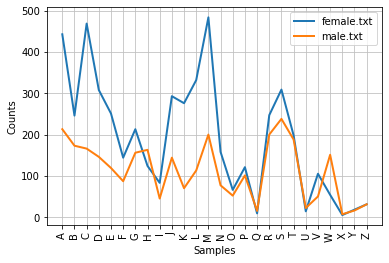

In [51]:
names = nltk.corpus.names
male_names = names.words('male.txt')
female_names = names.words('female.txt')

cfd = nltk.ConditionalFreqDist(
    (fileid, name[0])
    for fileid in names.fileids()
    for name in names.words(fileid))

cfd.plot();

###### 9.

◑ Pick a pair of texts and study the differences between them, in terms of vocabulary, vocabulary richness, genre, etc. Can you find pairs of words which have quite different meanings across the two texts, such as *monstrous* in *Moby Dick* and in *Sense and Sensibility*?

In [52]:
enclitics = ("d", "ll", "m", "re", "s", "t", "ve")

print("King James' Bible:")
num_chars = len([w for w in gutenberg.raw('bible-kjv.txt') if w.isalpha()])
num_words = len([w for w in gutenberg.words('bible-kjv.txt') if w.isalpha() and w not in enclitics])
num_sents = len(gutenberg.sents('bible-kjv.txt'))
num_vocab = len(set(w.lower() for w in gutenberg.words('bible-kjv.txt') if w.isalpha() and w not in enclitics))
print("Average number of characters per word:", round(num_chars/num_words))
print("Average number of words per sent:",  round(num_words/num_sents))
print("Lexical diversity: {:.5f}".format(num_vocab/num_words))
print("Total tokens: {:,}".format(num_words))
print("Total word types: {:,}".format(num_vocab))

King James' Bible:
Average number of characters per word: 4
Average number of words per sent: 26
Lexical diversity: 0.01591
Total tokens: 790,052
Total word types: 12,567


In [53]:
nltk.Text(gutenberg.words('bible-kjv.txt')).concordance("cool")

Displaying 2 of 2 matches:
ORD God walking in the garden in the cool of the day : and Adam and his wife h
the tip of his finger in water , and cool my tongue ; for I am tormented in th


In [54]:
enclitics = ("d", "ll", "m", "re", "s", "t", "ve")

print("'The Man Who Was Thursday' by G.K. Chesterton:")
num_chars = len([w for w in gutenberg.raw('chesterton-thursday.txt') if w.isalpha()])
num_words = len([w for w in gutenberg.words('chesterton-thursday.txt') if w.isalpha() and w not in enclitics])
num_sents = len(gutenberg.sents('chesterton-thursday.txt'))
num_vocab = len(set(w.lower() for w in gutenberg.words('chesterton-thursday.txt') if w.isalpha() and w not in enclitics))
print("Average number of characters per word:", round(num_chars/num_words))
print("Average number of words per sent:",  round(num_words/num_sents))
print("Lexical diversity: {:.5f}".format(num_vocab/num_words))
print("Total tokens: {:,}".format(num_words))
print("Total word types: {:,}".format(num_vocab))

'The Man Who Was Thursday' by G.K. Chesterton:
Average number of characters per word: 4
Average number of words per sent: 16
Lexical diversity: 0.10796
Total tokens: 58,297
Total word types: 6,294


In [55]:
nltk.Text(gutenberg.words('chesterton-thursday.txt')).concordance("cool")

Displaying 4 of 4 matches:
oke and pleasure out of pain . Yea , cool and clear and sudden as a bird sings
 " that you seem to have kept pretty cool under it . Now listen to me . I like
ok round . Syme , who was commonly a cool character , was literally gaping as 
in plunging into the wood they had a cool shock of shadow , as of divers who p


*I compared the King James' Bible and 'The Man Who Was Thursday' by G.K. Chesterton.  The bible is obviously a religious text, whereas Chesteron has been referred to as a mystery novel.  The bible is nearly 13 times as long and uses approximately twice as many words, but its lexical diversity is much lower, since the difference in length is not also reflected in the difference in vocabulary.  (It would be rare for a book to use much more than 10,000 word types, so in general, as texts get longer their lexical diversity will decrease.)*

*Since there aren't any newer texts in Project Gutenberg, it's difficult to compare texts to see changes in word usage over time.  However, we can find evidence that 'cool' changed in usage from merely describing temperature to also describing one's character.*

###### 10. 

◑ Read the [BBC News article: UK's Vicky Pollards 'left behind']( http://news.bbc.co.uk/2/hi/uk_news/education/6173441.stm. "Updated link") The article gives the following statistic about teen language: "the top 20 words used, including yeah, no, but and like, account for around a third of all words." How many word types account for a third of all word tokens, for a variety of text sources? What do you conclude about this statistic? Read more about this on [LanguageLog](http://itre.cis.upenn.edu/~myl/languagelog/archives/003993.html "LanguageLog").

*The answer to the main question is stated right there in the wording of the question: 20 words account for a third of all word tokens.  Furthermore, the BBC article doesn't mention a variety of text sources - only an analysis from Tony McEnery.*

*I've seen 'Little Britain' a handful of times and I am familiar with Vicky Pollard. I think a lot of the humor derives from the fact that people - especially teenagers - can say things that appear logically incongruent "yeah but, no but" that nevertheless carry meaning ("yes, I understand what you're saying, but no, I don't agree with you...").*

*The LanguageLog blog - without mentioning it - seems to be appealing to Zipf's Law, which we'll see later: i.e., a tiny minority of our vocabulary makes up the majority of our speech.*

###### 11. 

◑ Investigate the table of modal distributions and look for other patterns. Try to explain them in terms of your own impressionistic understanding of the different genres. Can you find other closed classes of words that exhibit significant differences across different genres?

In [56]:
cfd = nltk.ConditionalFreqDist(
    (genre, word) for genre in brown.categories() 
    for word in brown.words(categories = genre))
genres = ['news', 'religion', 'hobbies', 'science_fiction', 'romance', 'humor']
pronouns = ['I', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 
            'us', 'them']
cfd.tabulate(conditions = genres, samples = pronouns)

                   I  you   he  she   it   we they   me  him  her   us them 
           news  179   55  451   42  363   77  205   29   93  103   12   96 
       religion  155  100  137   10  264  176  115   31   60    8   59   74 
        hobbies  154  383  155   21  476  100  177   16   49   16   23  127 
science_fiction   98   81  139   36  129   30   53   20   58   71    6   47 
        romance  951  456  702  496  573   78  168  193  339  651   42  142 
          humor  239  131  146   58  162   32   70   56   48   62   23   49 


*I chose the closed set of English personal pronouns and made these observations: 'he' is much more common than 'she' - between three and ten times.  The sole exception is 'romance', where 'he' is a mere 40% more common than 'she'. 'Hobbies' is the only genre where 'you' is more common than 'I'. 'Romance' also shows a marked difference in the frequency of singular and plural pronouns.  First-person pronouns are much less common than third-person pronouns in 'news'.*

###### 12. 

◑ The CMU Pronouncing Dictionary contains multiple pronunciations for certain words. How many distinct words does it contain? What fraction of words in this dictionary have more than one possible pronunciation?

*Number of entries:*

In [57]:
cmu = nltk.corpus.cmudict.entries()
len(cmu)

133737

*Number of distinct words:*

In [58]:
distinct_words = sorted(set([w for w, p in cmu]))
len(distinct_words)


123455

*Percentage of words with more than one possible pronunciation:*

In [59]:
(len(cmu) - len(distinct_words)) / len(cmu)

0.07688223902136282

*For those pedantic types out there, the __fraction__ is $\frac{768,822,390,213}{10,000,000,000,000}$. Well, that's what the instructions asked for...*

###### 13.

◑ What percentage of noun synsets have no hyponyms? You can get all noun synsets using `wn.all_synsets('n')`.

*Nearly 80% of noun synsets have no hyponyms:*

In [60]:
no_hyponyms = 0

for n in list(wn.all_synsets('n')):
    if n.hyponyms() == []:
        no_hyponyms += 1
        
no_hyponyms/len(list(wn.all_synsets('n')))

0.7967119283931072

###### 14. 

◑ Define a function `supergloss(s)` that takes a synset `s` as its argument and returns a string consisting of the concatenation of the definition of `s`, and the definitions of all the hypernyms and hyponyms of `s`.

In [61]:
def supergloss(synset):
    """
    Prints a concatentation of a word and its definition, 
    along with the definitions of all of the word's hyper- and
    hyponyms.
    """
    full_stop = synset.index('.')
    term = synset[:full_stop]
    
    syn = wn.synset(synset)
    print(term + ":", syn.definition())
    
    
    print("\nHYPERNYMS:")
    for s in syn.hypernyms():
        names = []
        for name in s.lemma_names():
            names.append(name)
        print(", ".join(names) + ":", s.definition())

    print("\nHYPONYMS:")
    for s in syn.hyponyms():
        names = []
        for name in s.lemma_names():
            names.append(name)
        print(", ".join(names) + ":", s.definition())

In [62]:
supergloss('drum.n.01')

drum: a musical percussion instrument; usually consists of a hollow cylinder with a membrane stretched across each end

HYPERNYMS:
percussion_instrument, percussive_instrument: a musical instrument in which the sound is produced by one object striking another

HYPONYMS:
bass_drum, gran_casa: a large drum with two heads; makes a sound of indefinite but very low pitch
bongo, bongo_drum: a small drum; played with the hands
snare_drum, snare, side_drum: a small drum with two heads and a snare stretched across the lower head
tabor, tabour: a small drum with one head of soft calfskin
tambour: a drum
tambourine: a shallow drum with a single drumhead and with metallic disks in the sides
tenor_drum, tom-tom: any of various drums with small heads
timbrel: small hand drum similar to a tambourine; formerly carried by itinerant jugglers


###### 15.

◑ Write a program to find all words that occur at least three times in the Brown Corpus.

In [63]:
def find_words_occurring_thrice_or_more():
    """
    Returns a list of words that occur at least three times 
    in the Brown Corpus.
    """
    cfd = nltk.FreqDist(w.lower() for w in brown.words())
    wordtypes = set(w.lower() for w in brown.words())
    return [w for w in wordtypes if cfd[w] >= 3]

In [64]:
three_or_more = find_words_occurring_thrice_or_more()


In [65]:
len(three_or_more)

20615

In [66]:
three_or_more[:15]

['escorted',
 'discrimination',
 'handstands',
 'kitchenette',
 'witnesses',
 'lined',
 'exception',
 'typewriter',
 'captain',
 'delightfully',
 'commander-in-chief',
 'monarch',
 'explorers',
 "helva's",
 'significance']

In [67]:
cfd = nltk.FreqDist(w.lower() for w in brown.words())

for t in three_or_more[:15]:
    print(t + ":", cfd[t])

escorted: 5
discrimination: 23
handstands: 3
kitchenette: 3
witnesses: 21
lined: 16
exception: 40
typewriter: 10
captain: 85
delightfully: 4
commander-in-chief: 4
monarch: 3
explorers: 3
helva's: 8
significance: 66


*Although they haven't been introduced in the book yet, using a dictionary would be a faster and simpler way of getting a comparable result:*

In [68]:
d = dict()
for w in brown.words():
    d[w.lower()] = 1 + d.get(w.lower(), 0)
wordtypes = set(w.lower() for w in brown.words())
more_than_3 = [w for w in wordtypes if d[w] >= 3]
len(more_than_3)

20615

###### 16. 

◑ Write a program to generate a table of lexical diversity scores (i.e. token/type ratios), as we saw in 1.1. Include the full set of Brown Corpus genres (`nltk.corpus.brown.categories()`). Which genre has the lowest diversity (greatest number of tokens per type)? Is this what you would have expected?

*Re-using the function I made in my notes for chapter 1:*

*While making this function I needed code that could convert a string or a nested list into a flat list.  As I ended up using this code often, I decided to encase it in a new function:*

In [69]:
def coerce_to_list(text):
    """
    Coerces nested list or string to a flat list.
    """
    
    # flatten nested lists
    if type(text[0]) == list:
        text = [i for s in text for i in s]
    # convert strings to lists
    elif type(text) == str:
        text = text.split(" ")
        
    return list(text)
    

In [70]:
def lexical_diversity(text):
    """
    Returns the lexical diversity score of a text.
    Generally speaking, the less frequently words are 
    used on average in a text, the higher the score will be.
    """
    text = coerce_to_list(text)
    return len(set(text)) / len(text)

In [71]:
print("Lexical diversity scores: ")
for c in brown.categories():
    ld = lexical_diversity(brown.words(categories = c))
    print("{}: {} {}".format(c, " " * (15 - len(c)), ld))

Lexical diversity scores: 
adventure:        0.1279743878169075
belles_lettres:   0.10642071451679992
editorial:        0.16054152327770924
fiction:          0.1358194136199042
government:       0.11667641228232811
hobbies:          0.14493897625842492
humor:            0.23125144042406084
learned:          0.09268890745953554
lore:             0.13148804612915801
mystery:          0.12212912592488936
news:             0.14314696580941583
religion:         0.1617553745018909
reviews:          0.21192020440251572
romance:          0.12070492131044529
science_fiction:  0.22342778161713892


*Surprisingly, humor has the highest score, and learned the lowest.  Either humor is more sophisticated than one may assume (and scholarly literature less so), or lexical diversity is not a good measure of a text's complexity.*

*I hypothesized earlier than larger texts would have a lower lexical diversity than smaller ones, as the number of previously unseen words will go down exponentially with the size of the text.  Let's take a look at the sizes of the genres in the Brown Corpus to see if that supports my theory:*

In [72]:
print("Number of tokens per category: \t Lexical diversity:")
for c in brown.categories():
    t = len(brown.words(categories = c))
    ld = lexical_diversity(brown.words(categories = c))
    print("{}: {} {} \t {:.5f}".format(c, " " * (20 - len(c)), t, ld))

Number of tokens per category: 	 Lexical diversity:
adventure:             69342 	 0.12797
belles_lettres:        173096 	 0.10642
editorial:             61604 	 0.16054
fiction:               68488 	 0.13582
government:            70117 	 0.11668
hobbies:               82345 	 0.14494
humor:                 21695 	 0.23125
learned:               181888 	 0.09269
lore:                  110299 	 0.13149
mystery:               57169 	 0.12213
news:                  100554 	 0.14315
religion:              39399 	 0.16176
reviews:               40704 	 0.21192
romance:               70022 	 0.12070
science_fiction:       14470 	 0.22343


*As I thought, the genres with the largest number of tokens have the least lexical diversity. This isn't quite so easy to see as a table, so I'll graph it, instead.  Since the values have radically different scales, I'll normalize the values so that the maximum of each set of values is equal to 1.*

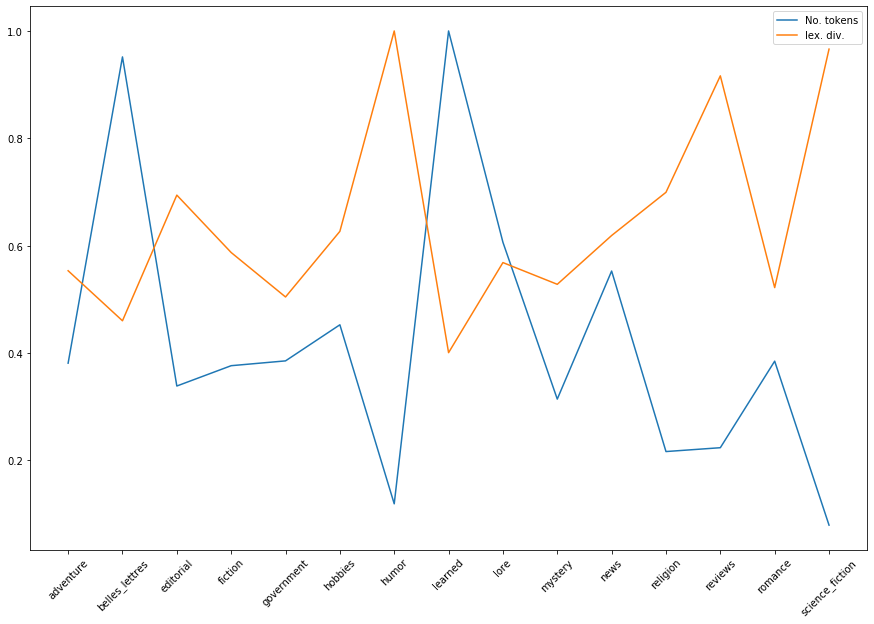

In [73]:
import matplotlib.pyplot as plt

tokens = []
lex_div = []

for c in brown.categories():
    tokens.append(len(brown.words(categories = c)))
    lex_div.append(lexical_diversity(brown.words(categories = c)))

# normalizing the arrays
tokens = [t/max(tokens) for t in tokens]
lex_div = [l/max(lex_div) for l in lex_div]

plt.figure(figsize = (15, 10))
plt.plot(tokens, label = "No. tokens")
plt.plot(lex_div, label = "lex. div.")
plt.legend()
plt.xticks(range(15), brown.categories(), rotation = 45)

plt.show()

*As you can see, the plots are almost exact inverses of each other: when one zigs, the other one zags.*

###### 17. 

◑ Write a function that finds the 50 most frequently occurring words of a text that are not stopwords.

In [74]:
from nltk.corpus import stopwords

def find_most_frequent_non_stopwords(text, n = 50, lang = 'english'):
    """
    From a text, returns the n most frequent words that are
    not stopwords.
    
    Arguments:
    
    text: Text to be analyzed
    n:    Number of most frequent words
    lang: The language from which stopwords are to be used.
          Default is English.
    """
    text = coerce_to_list(text)
    stopwords = nltk.corpus.stopwords.words('english')
    fd = nltk.FreqDist(w.lower() for w in text if w.lower().isalpha() and w.lower() not in stopwords)
    return fd.most_common(n)

In [75]:
print(find_most_frequent_non_stopwords(brown.words(), 50), end = '')

[('one', 3292), ('would', 2714), ('said', 1961), ('new', 1635), ('could', 1601), ('time', 1598), ('two', 1412), ('may', 1402), ('first', 1361), ('like', 1292), ('man', 1207), ('even', 1170), ('made', 1125), ('also', 1069), ('many', 1030), ('must', 1013), ('af', 996), ('back', 966), ('years', 950), ('much', 937), ('way', 908), ('well', 897), ('people', 847), ('little', 831), ('state', 807), ('good', 806), ('make', 794), ('world', 787), ('still', 782), ('see', 772), ('men', 763), ('work', 762), ('long', 752), ('get', 749), ('life', 715), ('never', 697), ('day', 687), ('another', 684), ('know', 683), ('last', 676), ('us', 675), ('might', 672), ('great', 665), ('old', 661), ('year', 658), ('come', 630), ('since', 628), ('go', 626), ('came', 622), ('right', 613)]

In [76]:
from nltk.corpus import gutenberg

print(find_most_frequent_non_stopwords(gutenberg.words('whitman-leaves.txt'), 50), end = '')


[('see', 432), ('one', 355), ('old', 278), ('love', 275), ('life', 267), ('day', 265), ('shall', 263), ('yet', 262), ('thee', 261), ('long', 253), ('soul', 249), ('earth', 246), ('man', 243), ('night', 226), ('thy', 226), ('thou', 209), ('men', 199), ('sea', 192), ('death', 190), ('every', 181), ('know', 176), ('time', 172), ('come', 171), ('ever', 167), ('well', 167), ('great', 163), ('upon', 156), ('world', 152), ('many', 145), ('good', 141), ('hear', 137), ('like', 135), ('never', 133), ('hand', 133), ('face', 132), ('body', 125), ('give', 125), ('far', 123), ('pass', 122), ('last', 121), ('young', 118), ('land', 118), ('look', 118), ('go', 114), ('rest', 111), ('us', 109), ('sing', 108), ('new', 108), ('dead', 108), ('air', 108)]

In [77]:
print(find_most_frequent_non_stopwords(brown.words(categories = 'humor'), 50), end = '')

[('said', 88), ('one', 77), ('would', 56), ('time', 44), ('even', 39), ('like', 36), ('could', 33), ('way', 28), ('things', 28), ('two', 26), ('get', 25), ('little', 25), ('mother', 24), ('arlene', 24), ('man', 23), ('made', 23), ('us', 23), ('years', 21), ('day', 21), ('never', 20), ('new', 20), ('children', 20), ('people', 20), ('told', 20), ('asked', 19), ('much', 19), ('say', 19), ('letch', 19), ('barco', 18), ('another', 18), ('long', 18), ('room', 18), ('old', 17), ('many', 17), ('home', 17), ('last', 17), ('always', 17), ('funny', 17), ('moreland', 17), ('back', 16), ('know', 16), ('something', 16), ('first', 15), ('seemed', 15), ('well', 15), ('around', 15), ('went', 15), ('called', 15), ('house', 15), ('comedy', 15)]

In [78]:
print(find_most_frequent_non_stopwords(brown.sents(categories = 'humor'), 50), end = '')

[('said', 88), ('one', 77), ('would', 56), ('time', 44), ('even', 39), ('like', 36), ('could', 33), ('way', 28), ('things', 28), ('two', 26), ('get', 25), ('little', 25), ('mother', 24), ('arlene', 24), ('man', 23), ('made', 23), ('us', 23), ('years', 21), ('day', 21), ('never', 20), ('new', 20), ('children', 20), ('people', 20), ('told', 20), ('asked', 19), ('much', 19), ('say', 19), ('letch', 19), ('barco', 18), ('another', 18), ('long', 18), ('room', 18), ('old', 17), ('many', 17), ('home', 17), ('last', 17), ('always', 17), ('funny', 17), ('moreland', 17), ('back', 16), ('know', 16), ('something', 16), ('first', 15), ('seemed', 15), ('well', 15), ('around', 15), ('went', 15), ('called', 15), ('house', 15), ('comedy', 15)]

*All of the words look quite common, with the exception of 'af'.  To make sure this isn't an error, let's print up some sentences with 'af':*

In [79]:
i = 0
for s in brown.sents():
    if "Af" in s:
        if i < 10:
            print(' '.join(s))
        i += 1


water is Af and the H stands for hydrogen ; ;
Salt water is still Af , the same hydrogen is there .
Start with the right-hand piece `` B '' , Af , soldering it to the lower piece `` A '' of the same material but 12'' '' long .
Now lay 12 pieces of Af cut 5-3/4'' '' long side by side but separated by 12 pieces of the same material 1/2'' '' sq. .
Cap this assembly ( with spacing bars in place ) with a Af bar .
Now cut five Af locking bar spacers ( which run horizontally ) .
Position these using six intermediate temporary Af spacers and locate the upper 12'' '' bar `` A '' .
Cap with a Af bar and tack-solder in place .
Cap the locking bar spacers with two Af directly under the first two `` B '' pieces .
Now reassemble the frame , using Af roundhead steel screws and nuts .


*It looks like 'af' may be used in some scientific/math texts, as well as some texts in the hobby genre.*

###### 18. 

◑ Write a program to print the 50 most frequent bigrams (pairs of adjacent words) of a text, omitting bigrams that contain stopwords.

In [80]:
def most_freq_bigrams_wo_stopwords(text, n = 50, lang = 'english'):
    """
    Returns a list of the most frequent bigrams in a 
    text that can be formed without using stopwords.
    
    Arguments:

    text: Text to be analyzed
    n:    Number of most frequent bigrams
    lang: The language from which stopwords are to be used.
          Default is English.
    
    """
    text = coerce_to_list(text)
    stopwords = nltk.corpus.stopwords.words(lang)
    bigrams = nltk.bigrams(w.lower() for w in text if w.lower().isalpha() and w.lower() not in stopwords)
    fd = nltk.FreqDist(bigrams)
    return fd.most_common(n)

In [81]:
print(most_freq_bigrams_wo_stopwords(brown.words()), end = '')

[(('united', 'states'), 392), (('new', 'york'), 296), (('per', 'cent'), 146), (('years', 'ago'), 138), (('af', 'af'), 129), (('could', 'see'), 93), (('rhode', 'island'), 91), (('last', 'year'), 78), (('even', 'though'), 77), (('high', 'school'), 74), (('white', 'house'), 68), (('first', 'time'), 68), (('old', 'man'), 68), (('world', 'war'), 66), (('two', 'years'), 62), (('let', 'us'), 62), (('one', 'thing'), 60), (('fiscal', 'year'), 58), (('last', 'night'), 57), (('peace', 'corps'), 55), (('one', 'day'), 53), (('one', 'another'), 52), (('would', 'like'), 51), (('last', 'week'), 51), (('united', 'nations'), 49), (('new', 'england'), 49), (('young', 'man'), 47), (('los', 'angeles'), 47), (('two', 'men'), 46), (('one', 'two'), 43), (('great', 'deal'), 43), (('civil', 'war'), 42), (('president', 'kennedy'), 41), (('would', 'make'), 41), (('time', 'time'), 41), (('general', 'motors'), 41), (('small', 'business'), 41), (('long', 'time'), 40), (('new', 'orleans'), 40), (('many', 'years'), 40

In [82]:
print(most_freq_bigrams_wo_stopwords(brown.sents()), end = '')

[(('united', 'states'), 392), (('new', 'york'), 296), (('per', 'cent'), 146), (('years', 'ago'), 138), (('af', 'af'), 129), (('could', 'see'), 93), (('rhode', 'island'), 91), (('last', 'year'), 78), (('even', 'though'), 77), (('high', 'school'), 74), (('white', 'house'), 68), (('first', 'time'), 68), (('old', 'man'), 68), (('world', 'war'), 66), (('two', 'years'), 62), (('let', 'us'), 62), (('one', 'thing'), 60), (('fiscal', 'year'), 58), (('last', 'night'), 57), (('peace', 'corps'), 55), (('one', 'day'), 53), (('one', 'another'), 52), (('would', 'like'), 51), (('last', 'week'), 51), (('united', 'nations'), 49), (('new', 'england'), 49), (('young', 'man'), 47), (('los', 'angeles'), 47), (('two', 'men'), 46), (('one', 'two'), 43), (('great', 'deal'), 43), (('civil', 'war'), 42), (('president', 'kennedy'), 41), (('would', 'make'), 41), (('time', 'time'), 41), (('general', 'motors'), 41), (('small', 'business'), 41), (('long', 'time'), 40), (('new', 'orleans'), 40), (('many', 'years'), 40

######  19.
◑ Write a program to create a table of word frequencies by genre, like the one given in 1 for modals. Choose your own words and try to find words whose presence (or absence) is typical of a genre. Discuss your findings.

*It's not difficult to adapt the code used in the book to show the distribution of modals; but more difficult would be to generalize a function that could work with almost any collections of texts, since each collection may have a different way of organizing distinct genres.*

In [83]:
cfd = nltk.ConditionalFreqDist(
            (genre, word)
            for genre in brown.categories()
            for word in brown.words(categories = genre))

arts = ['the', 'a', 'an', 'this', 'that', 'these', 'those']
cfd.tabulate(conditions = brown.categories(), samples = arts)

                  the     a    an  this  that these those 
      adventure  3370  1354   159   203   494    28    27 
 belles_lettres  9726  3308   583   627  1896   224   113 
      editorial  3508  1095   184   259   578    63    57 
        fiction  3423  1281   156   147   530    40    30 
     government  4143   867   208   344   489   107    61 
        hobbies  4300  1737   226   305   514   101    63 
          humor   930   505    75    59   241    16    10 
        learned 11079  3215   695   714  1695   314   137 
           lore  6328  2304   364   354   984   122    75 
        mystery  2573  1136   125   146   494    17    25 
           news  5580  1993   300   250   802    59    58 
       religion  2295   655   119   217   475    66    42 
        reviews  2048   874   163   143   336    29    24 
        romance  2758  1335   152   149   583    30    53 
science_fiction   652   222    33    49   126    12     7 


In [84]:
cfd = nltk.ConditionalFreqDist(
            (genre, word)
            for genre in brown.categories()
            for word in brown.words(categories = genre))

advs = ['really', 'very', 'extremely', 'bit', 'absolutely', 'completely', 'literally', 'thoroughly', 'totally', 'utterly']
cfd.tabulate(conditions = brown.categories(), samples = advs)

                    really       very  extremely        bit absolutely completely  literally thoroughly    totally    utterly 
      adventure         18         41          0         11          1          7          0          1          0          3 
 belles_lettres         36        123          8          5          7         15          4          3          1          6 
      editorial         19         48          3          6          3          5          0          2          4          0 
        fiction         25         42          0          5          2          3          0          1          1          1 
     government          1         22          4          0          0          4          0          4          1          2 
        hobbies         14         63         10         15          1         13          4          9          2          1 
          humor          6         24          0          8          0          0          1          1        

*I chose to look at adverbs that can be used with gradable (e.g., 'tired') and ungradable (e.g., 'exhausted) adjectives.  The difference between the two is that gradable adjectives can be modified by words which express their scale - e.g., we can be 'a little tired', 'somewhat tired', 'really tired'; but ungradable adjectives cannot.  As a consequence, ungradable adjectives are often used with adverbs like 'absolutely', 'completely', 'thoroughly' (and also 'literally', though normally this usage would be considered incorrect).*

*Unsurprisingly, the adverbs used with gradable adjectives ('really', 'very', 'extremely', 'bit' - representing 'a bit') are much more common than the rest of the adverbs, which are used with ungradable adjectives.  Also surprising is how often adverbs like 'very' are used in 'belle lettres' and 'learned', genres which we'd usually suspect to have a more diverse lexicon.*

###### 20.

◑ Write a function `word_freq()` that takes a word and the name of a section of the Brown Corpus as arguments, and computes the frequency of the word in that section of the corpus.

In [85]:
from nltk.corpus import brown

def word_freq(word, genre):
    """
    Computes the word frequency of a given section in the
    Brown Corpus.
    
    Arguments:
    word:  word to be tallyed
    genre: category in the Brown Corpus
    """
    i = 0
    for w in brown.words(categories = genre):
        if w.lower() == word.lower():
            i += 1
            
    return i

In [86]:
word_freq("President", "news")

142

###### 21.

◑ Write a program to guess the number of syllables contained in a text, making use of the CMU Pronouncing Dictionary.


In [87]:
def estimate_syllables(text):
    """
    Estimates the number of syllables in a text.  
    Text may be a list, a nested list, or a string.
    """
    cmu = nltk.corpus.cmudict.dict()
    total_syllables = 0
    
    text = coerce_to_list(text)
    
    for w in text:
        # only look up words, and ignore words not in cmu
        if w.isalpha() and w.lower() in cmu:
            # use the digits in the entires to calculate 
            # number of syllables
            for pron in (cmu[w.lower()][0]):
                for char in pron:
                    if char.isdigit():
                        total_syllables += 1
    return total_syllables

In [88]:
from nltk.corpus import gutenberg

print("{:,}".format(estimate_syllables(gutenberg.words('whitman-leaves.txt'))))

166,032


*My function will work with a list of words; a list of lists; or strings:*

In [89]:
from nltk.corpus import brown

print("{:,}".format(estimate_syllables(brown.words(categories = 'humor'))))

25,349


In [90]:
from nltk.corpus import brown

print("{:,}".format(estimate_syllables(brown.sents(categories = 'humor'))))

25,349


In [91]:
estimate_syllables("This is a test")

4

###### 22. 

◑ Define a function `hedge(text)` which processes a text and produces a new version with the word 'like' between every third word.

*I think the authors mean __after__ every third word.  For a group of linguists, the authors aren't especially articulate.*

*My code allows us to change the target word, as well as the interval where the new words will be inserted.  Further, it allows us to choose the output format: either a new string or a new list will be returned.*

*Finally, the code __literally__ inserts the target word after every $n$th word: it ignores punctuation and other non-alphabetic strings when it tallies where the new word should be inserted.*



In [92]:
def hedge(text, word, interval = 3, output = "string"):
    """
    Returns a modified version of a text with a specified word
    inserted at a designated interval.
    
    Arguments:
    
    text:     Text to be modified. Can be a list, nested list, or string.
    word:     Word to be inserted.  Must be a string.
    interval: After how many words should the target word be inserted? 
              Default value is three.
    output:   Output can be a new string or a new list.  Default is string.
    """
    
    text = coerce_to_list(text)
        
    if output == "string":
        
        newstring = ""
        i = 1
        for t in text:
            if t.isalpha() and i % interval == 0:
                newstring += t + " " + word + " "
                i += 1
            elif t.isalpha():    
                newstring += t + " "
                i += 1
            else:
                newstring += t + " "
        return newstring
    
    elif output == "list":
        
        newlist = []
        i = 1
        for t in text:
            if t.isalpha() and i % interval == 0:
                newlist.append(t)
                newlist.append(word)
                i += 1
            elif t.isalpha():    
                newlist.append(t)
                i += 1
            else:
                newlist.append(t)
        return newlist
    
    else:
        print("Sorry, the output can only be a string or a list.")
    

In [93]:
hedge("this is a test of a test for a test", "like")

'this is a like test of a like test for a like test '

In [94]:
print(hedge(brown.sents(categories = 'humor')[0:5], "like", output = "list"), end = '')

['It', 'was', 'among', 'like', 'these', 'that', 'Hinkle', 'like', 'identified', 'a', 'photograph', 'like', 'of', 'Barco', '!', '!', 'For', 'like', 'it', 'seems', 'that', 'like', 'Barco', ',', 'fancying', 'himself', 'like', 'a', "ladies'", 'man', '(', 'and', 'like', 'why', 'not', ',', 'after', 'like', 'seven', 'marriages', '?', '?', ')', ',', 'had', 'like', 'listed', 'himself', 'for', 'like', 'Mormon', 'Beard', 'roles', 'like', 'at', 'the', 'instigation', 'like', 'of', 'his', 'fourth', 'like', 'murder', 'victim', 'who', 'like', 'had', 'said', ':', '``', 'With', 'like', 'your', 'beard', ',', 'dear', 'like', ',', 'you', 'ought', 'to', 'like', 'be', 'in', 'movies', 'like', "''", '!', '!', 'Mills', 'secured', "Barco's", 'photograph', 'like', 'from', 'the', 'gentleman', 'like', 'in', 'charge', ',', 'rushed', 'like', 'to', 'the', 'Hollywood', 'like', 'police', 'station', 'to', 'like', 'report', 'the', 'theft', 'like', ',', 'and', 'less', 'than', 'like', 'five', 'minutes', 'later', 'like', ','

In [95]:
print(hedge(brown.words(categories = 'humor')[:120], "like", interval = 5), end = '')

It was among these that like Hinkle identified a photograph of like Barco ! ! For it seems that like Barco , fancying himself a ladies' man like ( and why not , after seven like marriages ? ? ) , had listed himself for like Mormon Beard roles at the like instigation of his fourth murder like victim who had said : `` With like your beard , dear , you ought like to be in movies '' ! ! Mills like secured Barco's photograph from the gentleman like in charge , rushed to the like Hollywood police station to report like the theft , and less than like five minutes later , detectives with like his picture in hand were like on the trail of Cal like Barco . On their way , they like stopped at 

###### 23. 

★ Zipf's Law: Let $f(w)$ be the frequency of a word $w$ in free text. Suppose that all the words of a text are ranked according to their frequency, with the most frequent word first. Zipf's law states that the frequency of a word type is inversely proportional to its rank (i.e. $f × r = k$, for some constant $k$). For example, the 50th most common word type should occur three times as frequently as the 150th most common word type.

* a. Write a function to process a large text and plot word frequency against word rank using `pylab.plot`. Do you confirm Zipf's law? (Hint: it helps to use a logarithmic scale). What is going on at the extreme ends of the plotted line?
    
* b. Generate random text, e.g., using `random.choice("abcdefg ")`, taking care to include the space character. You will need to import random first. Use the string concatenation operator to accumulate characters into a (very) long string. Then tokenize this string, and generate the Zipf plot as before, and compare the two plots. What do you make of Zipf's Law in the light of this?

*I first chose to do an analysis of "The Parent's Assistant" by Maria Edgeworth.  Using nltk `FreqDist` function, I was able to get the frequency distribution of the alphabetic strings in the text.*

In [96]:
ep = [w.lower() for w in gutenberg.words('edgeworth-parents.txt') if w.isalpha()]
fd = nltk.FreqDist(ep)

*Eyeballing the 50th and 150th most common words told me that Zipf's Law was roughly applicable here.  I.e. the 50th word, 'now', was 3.3 times as common as the 150th one, 'nothing'.*

In [97]:
fd.most_common(50)[-1]

('now', 508)

In [98]:
fd.most_common(150)[-1]

('nothing', 152)

*Getting the ranks and the counts for the plot involved some pretty convoluted line comprehensions, due to some idiosyncracies in Python syntax.  Firstly, `FreqDist` doesn't actually provide the numerical ranks, so I needed to use `enumerate` to generate those.  I also don't need the actual words from the distribution - only their frequencies - so at this point I can jettison them.  Since Python is zero-indexed, I have to add '1' to the enumeration, as I will use the log values of the ranks latter, and there is no log of zero.*

*At this point, I have a list of tuples, each of which has the rank and the counts.  To extract these values for my plot, I `zip` the values in my list, and assign them to the separate variables `ranks` and `counts`.*

In [99]:
ranks_counts = [(ranks + 1, counts) for ranks, counts in enumerate([counts for words, counts in fd.most_common(150)])]
ranks, counts = zip(*ranks_counts)

*Since I'd like to replicate this plot later, I encased everything in a function:*

In [100]:
import matplotlib.pyplot as plt
import numpy as np

def plot_Zipf(text, title = '', scale = 'log', n = 150, plot_style = 'k-', reg_line = 'c--'):
    """
    Generates a plot showing word rank against
    word frequency. 
    
    Arguments:
    text:       May be a list, nested list, or string
    title:      Optional title for the resulting plot
    scale:      May be 'log' or 'linear'.  Default is 'log'
    n:          Number of words considered.  Default is 150.
    plot_style: Style of the scatter plots.  Default is a
                black line.
    reg_line:   Style of the regression line.  Default
                is cyan dashes.
    """
    plt.figure(figsize=(15, 10))
    
    # coerce text to list
    text = coerce_to_list(text)
    
    # create frequency distribution
    edited = [w.lower() for w in text if w.isalpha()]
    fd = nltk.FreqDist(edited)
    
    # extract the ranks and accompanying counts
    ranks_counts = [(ranks + 1, counts) for ranks, counts in enumerate([counts for words, counts in fd.most_common(n)])]
    ranks, counts = zip(*ranks_counts)  
    
    plt.xscale(scale)
    plt.yscale(scale)
    
    if scale == 'log':
        plt.xlabel('Word Ranking (logarithmic scale)')
        plt.ylabel('Word Counts (logarithimc scale)')
        
        # adding regression line for log scale
        logR = np.log(np.asarray(ranks))
        logC = np.log(np.asarray(counts))

        m, c = np.polyfit(logR, logC, 1)
        y_fit = np.exp(m * logR + c)

        plt.plot(ranks, y_fit, reg_line)      
        
    else:
        plt.xlabel('Word Ranking')
        plt.ylabel('Word Counts')
    
    # add title if necessary
    if len(title) != 0:
        plt.title('Zipf analysis of {}'.format(title))
    else:
        plt.title('Zipf analysis of text')

    plt.plot(ranks, counts, plot_style)
    plt.show()

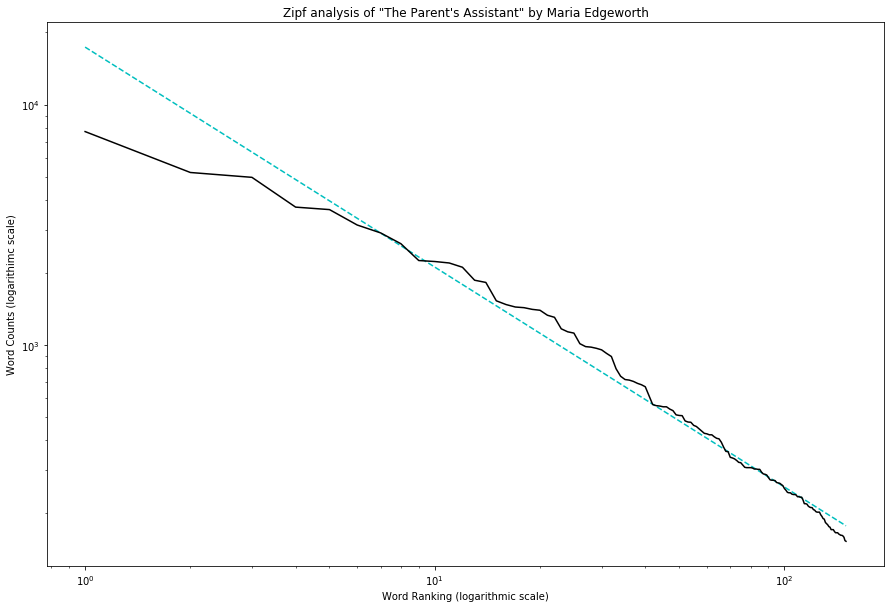

In [101]:
plot_Zipf(gutenberg.words('edgeworth-parents.txt'), title = '"The Parent\'s Assistant" by Maria Edgeworth', plot_style = 'k-')

*The plot basically shows what we'd expect: a roughly straight line when we plot the points on a logarithmic scale.  Let's a try a few more texts:*

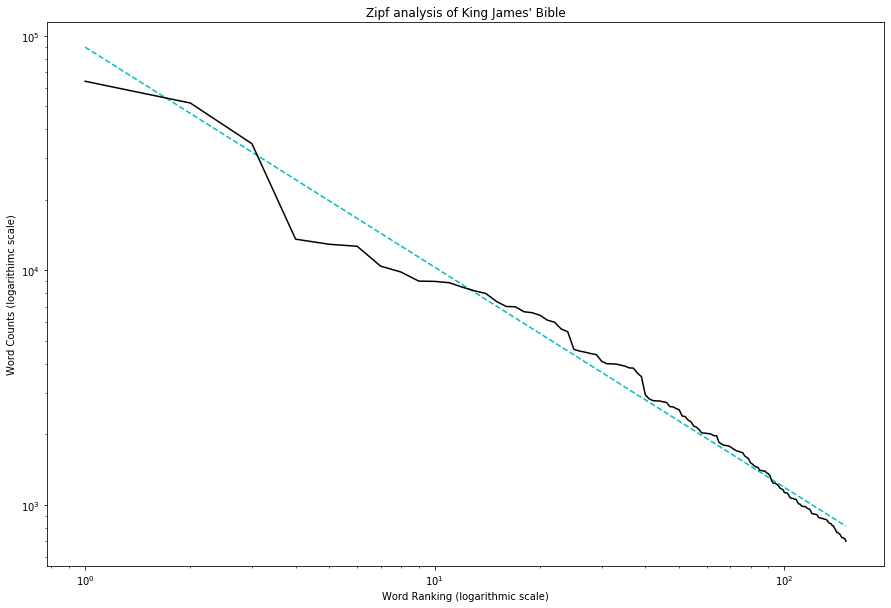

In [102]:
plot_Zipf(gutenberg.words('bible-kjv.txt'), title = 'King James\' Bible')

*The line seems a little jagged in places, but the overall trend is there.*

*With the collected texts in the Brown Corpus the plot is less linear, but again we can see the overall trend.*

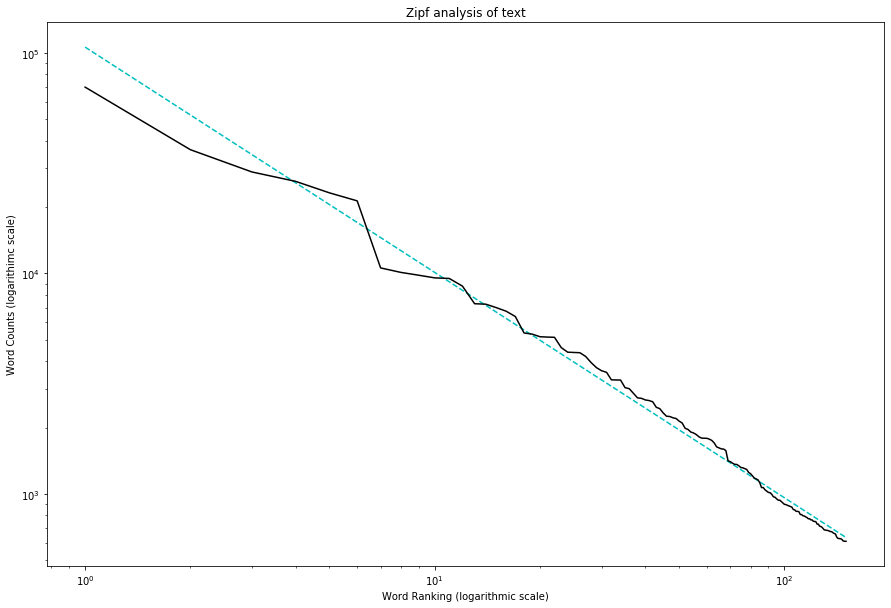

In [103]:
plot_Zipf(brown.sents())

*It will become much smoother if we increase the number of words analyzed.*

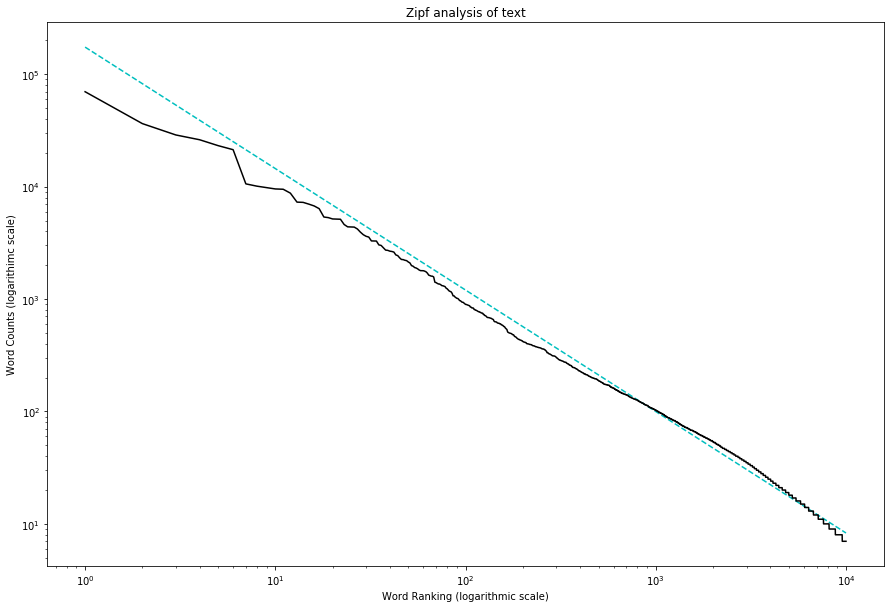

In [104]:
plot_Zipf(brown.sents(), n = 10000)

*Now we'll generate some random text for part B of this question:*

In [105]:
import random

test = ""

for i in range(5000000):
    test += random.choice("abcdefg ")


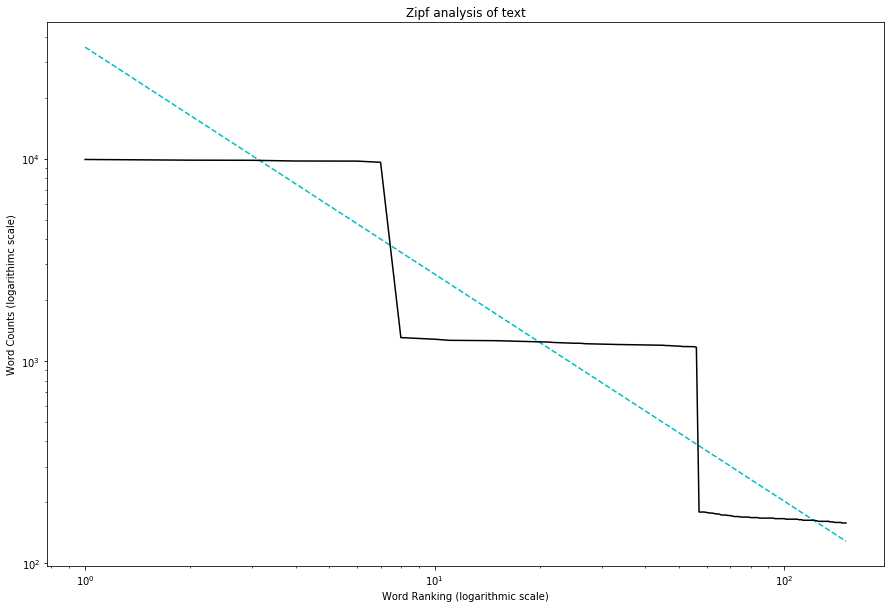

In [106]:
plot_Zipf(test)

*If you're curious, this is what the distribution would look like on a linear scale.*

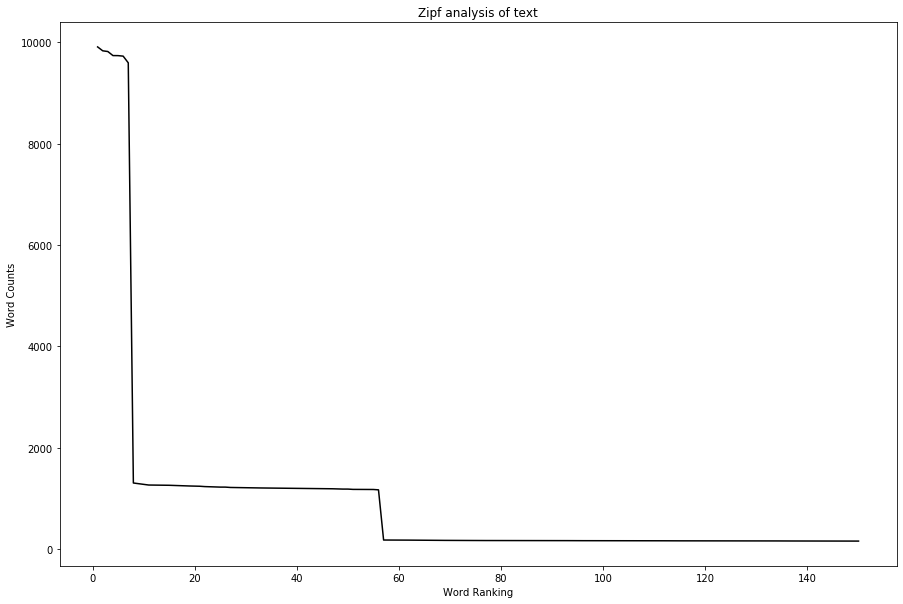

In [107]:
plot_Zipf(test, scale = "linear")

*The precise reasons why are beyond the scope of the book (it's a topic that large enough to be the subject of academic papers, cf. [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2834740/ "Zipf's law in random texts")), but the consensus seems to be that Zipf's Law does not apply for random texts.*

*Trying the test again, with all the letters of the alphabet and a larger text.*

In [108]:
import random

test2 = []

for i in range(80000000):
    test2.append(random.choice("abcdefghijklmnopqrstuvwxyz "))


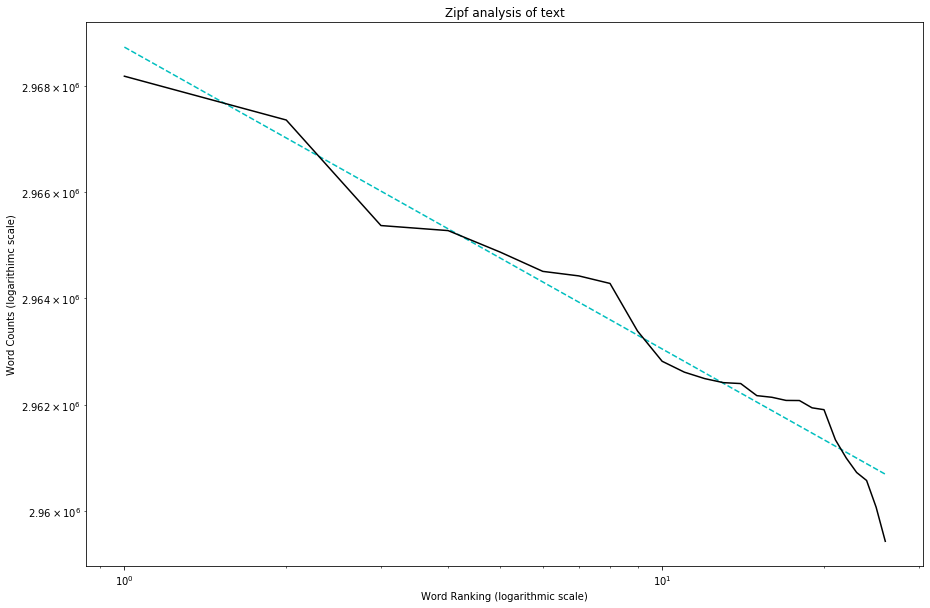

In [109]:
plot_Zipf(test2)

*With longer random texts, the distribution comes to resemble a Zipfian distribution.*


###### 24.

★ Modify the text generation program in [2.2](https://www.nltk.org/book/ch02.html#code-random-text "2.2") further, to do the following tasks:

* a. Store the $n$ most likely words in a list words then randomly choose a word from the list using `random.choice()`. (You will need to `import random` first.)
* b. Select a particular genre, such as a section of the Brown Corpus, or a genesis translation, one of the Gutenberg texts, or one of the Web texts. Train the model on this corpus and get it to generate random text. You may have to experiment with different start words. How intelligible is the text? Discuss the strengths and weaknesses of this method of generating random text.
* c. Now train your system using two distinct genres and experiment with generating text in the hybrid genre. Discuss your observations.

*As I noted in my notes for this chapter, the function in section 2.2 does not produce random text.  It is entirely deterministic, since the line `cfdist[word].max()` will always cause the function to choose the bigram with the highest frequency.  Therefore, if I use the exact same code as shown in the book, I should expect to get exactly the same result.*  

*To generate random text, I will have to use `random.choice()`; but `random.choice()` is not able to work on a `ConditionalFreqDist` unless we first isolate the `keys` and coerce them into a `list`.*

*I don't quite understand the point of part __a__ in the directions above.  It says we are to randomly choose a word from the $n$ most likely words in a text; but then it neglects to tell us what we should do with this word.  My assumption was that we should use this word to initialize a random text.  But in __b__ the instructions said we should experiment with different start words, which we can't do if we choose them randomly... Nonetheless, I like this idea of starting on a random word, so I built this functionality into my code.*



In [110]:
import random

def generate_random_text(text, num = 15, n = 50):
    """
    Uses a frequency distribution based upon a text to produce quasi-coherent
    random text.  Starting word is selected from a list of the n most common
    words in the text.
    
    Arguments:
    
    text: The text to be sampled from.  May be a string, list, or nested list.
    num:  The length in words of the string to be returned.
    n:    Size of the list of the nth most common words from which the 
          initial word is chosen.
    """
    # coerce to list
    text = coerce_to_list(text)
    
    # make a distribution of bigrams
    bigrams = nltk.bigrams(text)
    cfd = nltk.ConditionalFreqDist(bigrams)
    
    # create a list of the nth most likely words, and choose one to 
    # initialize the string of random words
    most_likely_words = nltk.FreqDist([w.lower() for w in text if w.isalpha()]).most_common(n)
    words, counts = zip(*most_likely_words)
    word = random.choice(words)
    
    # print out the current word, and randomly choose the subsequent word
    # from the cfd's keys
    for i in range(num):
        print(word, end = ' ')
        word = random.choice(list(cfd[word].keys()))
    

In [111]:
generate_random_text(nltk.corpus.genesis.words('english-kjv.txt'))

son had been twenty years the ward . Gad ; doth know now thou wroth 

In [112]:
generate_random_text(gutenberg.words('shakespeare-macbeth.txt'), num = 50)

all ' selfe should say God betimes remoue to mine eternall Curse fall , well Gent . Foule whisp ' faith with selfe , If ill : Feare , Sleep no words ; let me ? what hoa 2 Apparition , Gods benyson go with doubt it valiant Fury , 

In [113]:
generate_random_text(brown.sents(categories = 'lore'), num = 50)

had delayed menstruation . Never mind is essential , proximate goal of middle-class people have we are neither prosecuted because once said over four legs of buffalo and unattended horses and tails . Nara , personally friendly members understand why you will shute him mention something rather turn sets , 

In [114]:
generate_random_text(brown.words(categories = 'news'), num = 50)

he already been encouraging apartment seekers seem difficult problems which saw me and Hoyt Wilhelm , San Saba , J. Tuohy was found hidden in letters from Heritage collection closed at Blanchard's Chapel of hospital for hearing on Greenville Avenue , Alfred Kershbaum and marriages during `` Dallas members , 

In [115]:
generate_random_text(brown.words(categories = ['humor', 'news', 'religion']), num = 50)

they saw themselves compelled to these planets may by paid entertainers visiting Portland underwater fleet . Vladilen Semenov , Carol Jossy of investors standing next generation in Bow St. David's Church within the Humphrey to see this the voters to conceal at whatever the content of Chicago in winter was 

*The code is fun to play with, but there are some limitations: for one, we can only use bigrams.  The larger the size of the ngram, the more the text will resemble actual text.  Another limitation is the words are chosen at random, when we should actually be choosing more common words more frequently.*

*I believe I created a more useful set of functions to do this exact task when I was working my way through Allen Downey's [Think Python 2e](http://greenteapress.com/thinkpython2/html/thinkpython2014.html "Think Python Chapter 13").  My code uses dictionaries and Markov chains, neither of which have been so far in this book.  Although it's a bit more complex, it's still quite fast, and doesn't have the limitations of the code in chapter 2 of the NLTK book.*

*The complete code can be found in [my GitHub repo for my code for Think Python 2e](https://github.com/Sturzgefahr/ThinkPython/blob/master/Think%20Python%20-%20Chapter%2013/Think%20Python%20-%20Chapter%2013.ipynb "My code for Think Python 2e - Chapter 13").  The original code I wrote was designed to work on texts imported directly from the Project Gutenberg website.  This text is not tokenized and has lengthy legalese at the header and footer which has to be pruned before analysis.  I made a few alterations to the code so that it will work for the texts used here in the NLTK book:*

In [117]:
opened_text = open('alice.txt', 'r', encoding = "utf8")
alice = []
for line in opened_text:
    for word in line.split():
        alice.append(word.strip())

In [118]:
def make_ngram(array, index, n):
    """
    Returns a list of the n words following
    the word at the indexed point in the array.
    """
    ngram = []
    for j in range(1, n + 1):
        ngram.append(array[index + j])
    
    return ngram

def make_markov_dict(array, n):
    """
    Takes a list of words and returns a dictionary
    of all possible ngrams following each word in the array.
    """
    
    d = {}
    l = len(array)
    
    # adding padding so function doesn't crash at end of array
    array.extend(" " * n)
    
    for e in range(l):
        ngram = make_ngram(array, e, n)
        if array[e] not in d:
            d[array[e]] = ([ngram])
        else:
            d[array[e]] += ([ngram])
        
    # dictionary values for items at the end of the array
    # will have empty strings, and these need to be the
    # same size as the other values to prevent the code
    # from throwing an error
    
    d[" "] = " " * n
    return d

def minimarkov(d, word):
    """
    Randomly chooses one ngram from a Markov dictionary.
    """
    return(random.choice(d[word]))

def make_markov_text(text, n, length):
    """
    Takes a text, divides it into individual words, and the makes 
    a Markov dict for each word and all possible ngrams that
    follow it.  Then a word is randomly chosen, and of the ngrams
    that followed that word in the text, one is selected and 
    concatenated to the new text.  New text is printed.
    
    Arguments:
    text: a raw text 
    n: length of ngrams, i.e., words that occur together
        in the text.  The higher n, the more natural the 
        resulting text.
    length: number of ngrams to be concatenated. Length of final
        text will be 1 + n * length.
    """
    
    if type(text) != list:
        text = coerce_to_list(text)
        
    d = make_markov_dict(text, n)
    start = random.choice(list(d.keys()))
    markov_text = [start]
    
    for i in range(length):
        markov_text.extend(minimarkov(d, markov_text[-1]))
    for word in markov_text:
        print(word, end = " ")

In [119]:
make_markov_text(alice, 2, 20)

others round it is, too. I thought seemed to be sure I was!’ Humpty Dumpty relented. ‘It’s dreadfully confusing!’ ‘That’s the White Queen began again. A little men, so much more excuses, but pulled away. ‘I should be the garden first!’ 

In [120]:
make_markov_text(alice, 3, 20)

II. The Garden of ‘Ahoy! Ahoy! Check!’ and a Knight asked in a long way beyond it on each side,’ Alice added. ‘Exactly so. Well, this is the chimney-piece while she only said “if”--’ ‘But she said Alice, not wishing to begin an anxious tone, as she watched the gentleman dressed in tin armour, which happened to be going without a 

In [121]:
make_markov_text(alice, 4, 20)

Queen! How grand it sounds!’ A very few steps brought her to the feast’s over, we’ll go in at once--’ and your business.’ ‘My NAME is Alice, but--’ ‘It’s in a book.’ ‘Ah, well! They may write it down.’ ‘I will, though,’ the Queen said, rather sadly: ‘and SHE must help us to squeeze itself in among the flowers, poking its temper would remain!’ the Tiger-lily only went on with ‘The man that was beginning. At this moment a heavy crash 

In [122]:
make_markov_text(alice, 5, 20)

possible, as if it were quite reach it.’ ‘And it certainly looked much more like a severe tone (she was always rather fond of scolding herself), ‘it’ll never do for you VERY much for asking,’ said rather impatiently. ‘I don’t belong to this railway journey at all nice, you know.’ The Frog looked at the door was shut, I tried to deny. ‘Who did you pass anything. ‘I wonder if all the guests began drinking it happened on purpose,’ she thought) that, though she managed to shut out the dreadful uproar. ‘If THAT doesn’t “drum them into waistcoat-buttons In the silent 

In [123]:
make_markov_text(gutenberg.words('shakespeare-macbeth.txt'), 2, 20)

treasure Of Natures Coppie ' st vpon the Stage : byth ' Clock ' tis my limitted seruice . What ? speake , Knock . What is a place , Was ' t , And shew the speed of our Watch 

In [124]:
make_markov_text(brown.words(), 4, 20)

Quacks are apt to direct and powerful mirror in Washington , D. C. Orvis , manager of the farm to you have made of a horse-trail across the stream , or lake provides identification -- with an influential marriage . Unlike the Sicilians , he said the odds appear in American Artist again in his mind like a fool , too much trouble even to tell on Rob Roy first painted subjects he did feel fell into one or more of 

In [125]:
make_markov_text(brown.sents(), 5, 20)

tragedy . Among the visitors arriving at Adjusted Gross Income . To be passive , to be able to do anything , it is the therapist's intuitive sensing of these latent one , of the process is called bargaining . When I hold my son he had been booked on and disaster to business , tolerated . In defiance , a different brand is called for the unemployed , their children , for his pay , and he had no intention to establish automobile racing as joyous as this one did not retort . The sitter must decide whether the statements 

###### 25. 

★ Define a function `find_language()` that takes a string as its argument, and returns a list of languages that have that string as a word. Use the `udhr` corpus and limit your searches to files in the Latin-1 encoding.

*The function is cute, but considering how short the Universal Declaration of Human Rights is, it's not very useful for this sort of task...*

In [126]:
from nltk.corpus import udhr

def find_language(word):
    """
    Returns a list of languages which use a given word
    in their Universal Declaration of Human Rights.
    """
    latin1_langs = [l for l in udhr.fileids() if l.endswith('Latin1')]
    matches = []
    for l in latin1_langs:
        if word in udhr.words(l):
            matches.append(l[:-7])
            
    return matches

In [127]:
print(find_language('man'), end = '')

['Bichelamar', 'Bikol_Bicolano', 'Cakchiquel', 'Chamorro', 'Chuuk_Trukese', 'English', 'Friulian_Friulano', 'Hiligaynon', 'Ibibio_Efik', 'Iloko_Ilocano', 'Kapampangan', 'Kiche_Quiche', 'Luxembourgish_Letzebuergeusch', 'Mam', 'Marshallese', 'NigerianPidginEnglish', 'Sharanahua', 'SolomonsPidgin_Pijin', 'Tiv', 'TokPisin', 'Trukese_Chuuk', 'Waray']

In [128]:
print(find_language('and'), end = '')

['Albanian_Shqip', 'Bemba', 'Cebuano', 'English', 'NigerianPidginEnglish', 'Romani']

###### 26. 
★ What is the branching factor of the noun hypernym hierarchy? I.e. for every noun synset that has hyponyms — or children in the hypernym hierarchy — how many do they have on average? You can get all noun synsets using `wn.all_synsets('n')`.

*I found the question to be a little bit confusing: in the beginning they asked for the branching factor of hypernyms; but later they seemed to be asked for the branching facter of hyponyms.  However, it makes sense in the end, since the two numbers are the same.  I.e., the number of branches (or edges, if we're looking at it as a network) will be the same whether we look from the top down or from the bottom up.*

In [129]:
from nltk.corpus import wordnet as wn

l = list(wn.all_synsets('n'))

hypo_branches = []
for i in l:
    hypo_branches.append(len(i.hyponyms()))

sum(hypo_branches)/len(hypo_branches)

0.9237045606770992

In [130]:
hyper_branches = []
for i in l:
    hyper_branches.append(len(i.hypernyms()))
sum(hyper_branches)/len(hyper_branches)

0.9237045606770992

###### 27. 

★ The polysemy of a word is the number of senses it has. Using WordNet, we can determine that the noun dog has 7 senses with: `len(wn.synsets('dog', 'n'))`. Compute the average polysemy of nouns, verbs, adjectives and adverbs according to WordNet.

*We can get all the items for a part of speech by using `list(wn.all_synsets('v'))`.  However, the items in this list can be of differing lengths:*

In [131]:
l = list(wn.all_synsets('v'))
for syn in l[:5]:
    print(syn.lemma_names())

['breathe', 'take_a_breath', 'respire', 'suspire']
['respire']
['respire']
['choke']
['hyperventilate']


*And it would be inaccurate to assume that the various entries for a given item have the same number of senses:*

In [132]:
len(wn.synsets('breathe', 'v'))

9

In [133]:
len(wn.synsets('take_a_breath', 'v'))


1

*So we need to get all the entries for each item.*

*Also remark that the word `respire` appears twice.  Seeing one word twice in such a small samples indicates that it's likely that there are many more duplicates in this list of items, and counting duplicates multiple times will throw off our counts.*

In [134]:
pos = ['nouns', 'verbs', 'adjectives', 'adverbs']
abb = ['n', 'v', 'a', 'r']
ave_poly = []

for i in range(len(pos)):
    # get all items for this part of speech
    syn_list = list(wn.all_synsets(abb[i]))  
    
    entries = []
    for syn in syn_list:
        # some items have more than one entry, so we need to
        # make sure all entries are accounted for
        for entry in syn.lemma_names():
            entries.append(entry)
     
    # if a word has x senses, it will be in this list x times, 
    # so we need to get rid of duplicates   
    entries = set(entries)
    
    # tally of senses for this pos
    polysemy = 0
    
    # iterate through entries and add number of senses
    for entry in set(entries):
        polysemy += len(wn.synsets(entry, abb[i]))
            
    
    ave_poly.append(polysemy/len(entries))  
    
for i in range(len(pos)):
    print("The average polysemy for the {} in WordNet is {:.5f}.".format(pos[i], ave_poly[i]))
    

The average polysemy for the nouns in WordNet is 1.28336.
The average polysemy for the verbs in WordNet is 2.18663.
The average polysemy for the adjectives in WordNet is 1.41048.
The average polysemy for the adverbs in WordNet is 1.25329.


###### 28. 

★ Use one of the predefined similarity measures to score the similarity of each of the following pairs of words. Rank the pairs in order of decreasing similarity. How close is your ranking to the order given here, an order that was established experimentally by (Miller & Charles, 1998): car-automobile, gem-jewel, journey-voyage, boy-lad, coast-shore, asylum-madhouse, magician-wizard, midday-noon, furnace-stove, food-fruit, bird-cock, bird-crane, tool-implement, brother-monk, lad-brother, crane-implement, journey-car, monk-oracle, cemetery-woodland, food-rooster, coast-hill, forest-graveyard, shore-woodland, monk-slave, coast-forest, lad-wizard, chord-smile, glass-magician, rooster-voyage, noon-string.

*I couldn't find the original paper, but I found the scores [here](https://www.semanticscholar.org/paper/Roget's-Thesaurus-and-Semantic-Similarity-Jarmasz-Szpakowicz/a67f083830790586ed41823d45a7b330d0a2fd95/figure/0 "Miller-Charles' Scores").  __N.B.__ there seem to be several slightly differing versions of the word pair listing online.*


| Word Pair        | Miller-Charles' Score |
|------------------|-----------------|
| automobile-car   | 3.92            |
| gem-jewel        | 3.84            |
| journey-voyage   | 3.84            |
| boy-lad          | 3.76            |
| coast-shore      | 3.7             |
| asylum-madhouse  | 3.61            |
| magician-wizard  | 3.5             |
| midday-noon      | 3.42            |
| furnace-stove    | 3.11            |
| food-fruit       | 3.08            |
| bird-cock        | 3.05            |
| bird-crane       | 2.97            |
| implement-tool   | 2.95            |
| brother-monk     | 2.82            |
| crane-implement  | 1.68            |
| brother-lad      | 1.66            |
| car-journey      | 1.16            |
| monk-oracle      | 1.1             |
| cemetery-woodland| 0.95            |
| food-rooster     | 0.89            |
| coast-hill       | 0.87            |
| forest-graveyard | 0.84            |
| shore-woodland   | 0.63            |
| monk-slave       | 0.55            |
| coast-forest     | 0.42            |
| lad-wizard       | 0.42            |
| chord-smile      | 0.13            |
| glass-magician   | 0.11            |
| rooster-voyage   | 0.08            |
| noon-string      | 0.08            |

In [135]:
 pairs = [["car", "automobile"], 
          ["gem", "jewel"], 
          ["journey", "voyage"], 
          ["boy", "lad"], 
          ["coast", "shore"], 
          ["asylum", "madhouse"], 
          ["magician", "wizard"], 
          ["midday", "noon"], 
          ["furnace", "stove"], 
          ["food", "fruit"], 
          ["bird", "cock"], 
          ["bird", "crane"], 
          ["tool", "implement"], 
          ["brother", "monk"], 
          ["lad", "brother"], 
          ["crane", "implement"], 
          ["journey", "car"], 
          ["monk", "oracle"], 
          ["cemetery", "woodland"], 
          ["food", "rooster"], 
          ["coast", "hill"], 
          ["forest", "graveyard"], 
          ["shore", "woodland"], 
          ["monk", "slave"], 
          ["coast", "forest"], 
          ["lad", "wizard"], 
          ["chord", "smile"], 
          ["glass", "magician"], 
          ["rooster", "voyage"], 
          ["noon", "string"]]

*The first check I did was with the `path_similarity` function, which was demonstrated in [section 5.4 of this chapter of the NLTK book](https://www.nltk.org/book/ch02.html#semantic-similarity "Semantic Similarity").*

*One issue that arose was that of polysemy: the various senses of a word would have different semantic similarity scores, and there isn't an expedient method for deciding which sense of a word would be best to use.  Therefore, I decided to iterate through all the pair of senses and take the one with the highest similarity score.* 

In [136]:
path_sim_scores = []
for pair in pairs:

    scores = []
    # iterate through all the different senses and take the 
    # one with the highest similarity score
    for i in range(1, len(wn.synsets(pair[0], 'n')) + 1):
        for j in range(1, len(wn.synsets(pair[1], 'n')) + 1):
            first = wn.synset(pair[0] + '.n.' + str(i))
            second = wn.synset(pair[1] + '.n.' + str(j))
            scores.append(first.path_similarity(second))
    path_sim_scores.append([max(scores), (pair[0], pair[1])])

*`path_similarity` gave different rankings than Miller-Charles'.  Without having access to their methodology it's difficult to offer any sort of critique, but I'm hard pressed to explain, amongst other things, how a pairing of "journey-voyage" could be considered more similar than "midday-noon".*

In [137]:
# sort the pairs by score
sorted(path_sim_scores, reverse = True)

[[1.0, ('midday', 'noon')],
 [1.0, ('magician', 'wizard')],
 [1.0, ('gem', 'jewel')],
 [1.0, ('car', 'automobile')],
 [0.5, ('tool', 'implement')],
 [0.5, ('journey', 'voyage')],
 [0.5, ('coast', 'shore')],
 [0.5, ('brother', 'monk')],
 [0.5, ('boy', 'lad')],
 [0.5, ('bird', 'cock')],
 [0.5, ('asylum', 'madhouse')],
 [0.25, ('bird', 'crane')],
 [0.2, ('shore', 'woodland')],
 [0.2, ('monk', 'slave')],
 [0.2, ('lad', 'wizard')],
 [0.2, ('lad', 'brother')],
 [0.2, ('crane', 'implement')],
 [0.2, ('coast', 'hill')],
 [0.16666666666666666, ('coast', 'forest')],
 [0.125, ('monk', 'oracle')],
 [0.125, ('glass', 'magician')],
 [0.1111111111111111, ('forest', 'graveyard')],
 [0.1111111111111111, ('cemetery', 'woodland')],
 [0.1, ('furnace', 'stove')],
 [0.1, ('food', 'fruit')],
 [0.09090909090909091, ('chord', 'smile')],
 [0.08333333333333333, ('noon', 'string')],
 [0.0625, ('food', 'rooster')],
 [0.05555555555555555, ('journey', 'car')],
 [0.041666666666666664, ('rooster', 'voyage')]]

*The Leacock-Chodorow Similarity method (`lch_similarity`) gave different scores, but the same ranking as `path_similarity`:*

In [138]:
lch_sim_scores = []
for pair in pairs:

    scores = []
    for i in range(1, len(wn.synsets(pair[0], 'n')) + 1):
        for j in range(1, len(wn.synsets(pair[1], 'n')) + 1):
            first = wn.synset(pair[0] + '.n.' + str(i))
            second = wn.synset(pair[1] + '.n.' + str(j))
            scores.append(first.lch_similarity(second))
    lch_sim_scores.append([max(scores), (pair[0], pair[1])])

In [139]:
sorted(lch_sim_scores, reverse = True)

[[3.6375861597263857, ('midday', 'noon')],
 [3.6375861597263857, ('magician', 'wizard')],
 [3.6375861597263857, ('gem', 'jewel')],
 [3.6375861597263857, ('car', 'automobile')],
 [2.9444389791664407, ('tool', 'implement')],
 [2.9444389791664407, ('journey', 'voyage')],
 [2.9444389791664407, ('coast', 'shore')],
 [2.9444389791664407, ('brother', 'monk')],
 [2.9444389791664407, ('boy', 'lad')],
 [2.9444389791664407, ('bird', 'cock')],
 [2.9444389791664407, ('asylum', 'madhouse')],
 [2.2512917986064953, ('bird', 'crane')],
 [2.0281482472922856, ('shore', 'woodland')],
 [2.0281482472922856, ('monk', 'slave')],
 [2.0281482472922856, ('lad', 'wizard')],
 [2.0281482472922856, ('lad', 'brother')],
 [2.0281482472922856, ('crane', 'implement')],
 [2.0281482472922856, ('coast', 'hill')],
 [1.845826690498331, ('coast', 'forest')],
 [1.55814461804655, ('monk', 'oracle')],
 [1.55814461804655, ('glass', 'magician')],
 [1.4403615823901665, ('forest', 'graveyard')],
 [1.4403615823901665, ('cemetery', 'w

*Wu-Palmer Similarity gave a slightly different ranking than the above methods:*

In [140]:
wup_sim_scores = []
for pair in pairs:

    scores = []
    for i in range(1, len(wn.synsets(pair[0], 'n')) + 1):
        for j in range(1, len(wn.synsets(pair[1], 'n')) + 1):
            first = wn.synset(pair[0] + '.n.' + str(i))
            second = wn.synset(pair[1] + '.n.' + str(j))
            scores.append(first.wup_similarity(second))
    wup_sim_scores.append([max(scores), (pair[0], pair[1])])

sorted(wup_sim_scores, reverse = True)

[[1.0, ('midday', 'noon')],
 [1.0, ('magician', 'wizard')],
 [1.0, ('gem', 'jewel')],
 [1.0, ('car', 'automobile')],
 [0.9523809523809523, ('journey', 'voyage')],
 [0.9523809523809523, ('brother', 'monk')],
 [0.9523809523809523, ('bird', 'cock')],
 [0.9523809523809523, ('asylum', 'madhouse')],
 [0.9473684210526315, ('boy', 'lad')],
 [0.9333333333333333, ('tool', 'implement')],
 [0.9090909090909091, ('coast', 'shore')],
 [0.8695652173913043, ('bird', 'crane')],
 [0.75, ('crane', 'implement')],
 [0.6666666666666666, ('monk', 'slave')],
 [0.6666666666666666, ('lad', 'wizard')],
 [0.6666666666666666, ('lad', 'brother')],
 [0.6666666666666666, ('coast', 'hill')],
 [0.6, ('shore', 'woodland')],
 [0.5714285714285714, ('monk', 'oracle')],
 [0.5454545454545454, ('coast', 'forest')],
 [0.5263157894736842, ('furnace', 'stove')],
 [0.47058823529411764, ('glass', 'magician')],
 [0.42857142857142855, ('forest', 'graveyard')],
 [0.42857142857142855, ('cemetery', 'woodland')],
 [0.4, ('food', 'fruit')

*The following similarity measures require us to import an information content file from the wordnet_ic corpus:*

In [141]:
from nltk.corpus import wordnet_ic
brown_ic = wordnet_ic.ic('ic-brown.dat')
semcor_ic = wordnet_ic.ic('ic-semcor.dat')

*First, Resnik similarity with the Brown IC file:*

In [142]:
res_brown_sim_scores = []
for pair in pairs:

    scores = []
    for i in range(1, len(wn.synsets(pair[0], 'n')) + 1):
        for j in range(1, len(wn.synsets(pair[1], 'n')) + 1):
            first = wn.synset(pair[0] + '.n.' + str(i))
            second = wn.synset(pair[1] + '.n.' + str(j))
            scores.append(first.res_similarity(second, brown_ic))
    res_brown_sim_scores.append([max(scores), (pair[0], pair[1])])

sorted(res_brown_sim_scores, reverse = True)

[[12.067704640264017, ('gem', 'jewel')],
 [11.980693263274388, ('magician', 'wizard')],
 [11.064402531400233, ('midday', 'noon')],
 [9.475167326283652, ('asylum', 'madhouse')],
 [9.415743905812851, ('coast', 'shore')],
 [9.261593225985592, ('brother', 'monk')],
 [8.399491822958641, ('boy', 'lad')],
 [7.677754930752808, ('bird', 'crane')],
 [7.677754930752808, ('bird', 'cock')],
 [7.591401417609093, ('car', 'automobile')],
 [6.825957625204375, ('journey', 'voyage')],
 [5.884681030765606, ('coast', 'hill')],
 [5.87738923441087, ('tool', 'implement')],
 [3.2576790258866897, ('crane', 'implement')],
 [2.61964384137646, ('chord', 'smile')],
 [2.333545243735693, ('monk', 'slave')],
 [2.333545243735693, ('monk', 'oracle')],
 [2.333545243735693, ('lad', 'wizard')],
 [2.333545243735693, ('lad', 'brother')],
 [2.305848731451232, ('furnace', 'stove')],
 [2.282647491973017, ('glass', 'magician')],
 [1.5927548636075812, ('food', 'fruit')],
 [1.2900256809649917, ('shore', 'woodland')],
 [1.290025680

*Some values - such as ('asylum", 'madhouse') - have moved quite a bit.*

*Resnik similarity again, but with the Semcor IC file:*

In [143]:
# With the Brown information content file

res_semcor_sim_scores = []
for pair in pairs:

    scores = []
    for i in range(1, len(wn.synsets(pair[0], 'n')) + 1):
        for j in range(1, len(wn.synsets(pair[1], 'n')) + 1):
            first = wn.synset(pair[0] + '.n.' + str(i))
            second = wn.synset(pair[1] + '.n.' + str(j))
            scores.append(first.res_similarity(second, semcor_ic))
    res_semcor_sim_scores.append([max(scores), (pair[0], pair[1])])

sorted(res_semcor_sim_scores, reverse = True)

[[1e+300, ('gem', 'jewel')],
 [11.072612668084629, ('magician', 'wizard')],
 [10.667147559976465, ('asylum', 'madhouse')],
 [10.156321936210475, ('brother', 'monk')],
 [9.568535271308354, ('midday', 'noon')],
 [8.102198202514929, ('coast', 'shore')],
 [7.140787035360304, ('journey', 'voyage')],
 [7.003585913846818, ('car', 'automobile')],
 [6.937446111342273, ('bird', 'crane')],
 [6.937446111342273, ('bird', 'cock')],
 [6.741879327798298, ('boy', 'lad')],
 [6.3104387332868725, ('tool', 'implement')],
 [6.138138734953937, ('coast', 'hill')],
 [3.445068277596125, ('crane', 'implement')],
 [3.071760281122492, ('chord', 'smile')],
 [2.493384085748939, ('furnace', 'stove')],
 [1.9033026456664381, ('monk', 'slave')],
 [1.9033026456664381, ('monk', 'oracle')],
 [1.9033026456664381, ('lad', 'wizard')],
 [1.9033026456664381, ('lad', 'brother')],
 [1.8746991911165738, ('glass', 'magician')],
 [1.7798171161722536, ('food', 'fruit')],
 [1.1692001183611416, ('shore', 'woodland')],
 [1.1692001183611

*Resnik similarity with the two IC files gave similar - but not identical - results.*

*The Jiang-Conrath Similarity also needs IC files, so we'll try it twice: first with the Brown IC files:*

In [144]:
jcn_brown_sim_scores = []
for pair in pairs:

    scores = []
    for i in range(1, len(wn.synsets(pair[0], 'n')) + 1):
        for j in range(1, len(wn.synsets(pair[1], 'n')) + 1):
            first = wn.synset(pair[0] + '.n.' + str(i))
            second = wn.synset(pair[1] + '.n.' + str(j))
            scores.append(first.jcn_similarity(second, brown_ic))
    jcn_brown_sim_scores.append([max(scores), (pair[0], pair[1])])

sorted(jcn_brown_sim_scores, reverse = True)

[[1e+300, ('midday', 'noon')],
 [1e+300, ('magician', 'wizard')],
 [1e+300, ('gem', 'jewel')],
 [1e+300, ('car', 'automobile')],
 [3.91777688470154, ('brother', 'monk')],
 [1.524742319195391, ('tool', 'implement')],
 [1.3905833398673364, ('coast', 'shore')],
 [0.31262963211624767, ('asylum', 'madhouse')],
 [0.2917960864569923, ('boy', 'lad')],
 [0.2562806264117196, ('journey', 'voyage')],
 [0.22295252107511723, ('bird', 'cock')],
 [0.19310957723222136, ('bird', 'crane')],
 [0.12697965461225075, ('coast', 'hill')],
 [0.09150386768607839, ('food', 'fruit')],
 [0.08598151736322068, ('crane', 'implement')],
 [0.0734069276489804, ('lad', 'brother')],
 [0.07337477103699754, ('lad', 'wizard')],
 [0.07307364582678529, ('monk', 'slave')],
 [0.0693608307201355, ('journey', 'car')],
 [0.06409104911742998, ('furnace', 'stove')],
 [0.06313551271889126, ('food', 'rooster')],
 [0.062439198995426916, ('monk', 'oracle')],
 [0.062357662794309016, ('chord', 'smile')],
 [0.060793000212738556, ('shore', 'w

*And again with the Semcor IC file:*

In [145]:
# With the Brown information content file

jcn_semcor_sim_scores = []
for pair in pairs:

    scores = []
    for i in range(1, len(wn.synsets(pair[0], 'n')) + 1):
        for j in range(1, len(wn.synsets(pair[1], 'n')) + 1):
            first = wn.synset(pair[0] + '.n.' + str(i))
            second = wn.synset(pair[1] + '.n.' + str(j))
            scores.append(first.jcn_similarity(second, semcor_ic))
    jcn_semcor_sim_scores.append([max(scores), (pair[0], pair[1])])

sorted(jcn_semcor_sim_scores, reverse = True)

[[1e+300, ('midday', 'noon')],
 [1e+300, ('magician', 'wizard')],
 [1e+300, ('gem', 'jewel')],
 [1e+300, ('car', 'automobile')],
 [2.4663034623764357, ('asylum', 'madhouse')],
 [1.6154065629778043, ('coast', 'shore')],
 [0.8484246900949288, ('tool', 'implement')],
 [0.3533884661459109, ('journey', 'voyage')],
 [0.29287357108779505, ('boy', 'lad')],
 [0.2681179750637138, ('bird', 'cock')],
 [0.21866844070659408, ('coast', 'hill')],
 [0.08607225144270927, ('food', 'fruit')],
 [0.08296308648149416, ('lad', 'brother')],
 [0.07904013229162012, ('chord', 'smile')],
 [0.07587503982877675, ('lad', 'wizard')],
 [0.07069949326074976, ('journey', 'car')],
 [0.06894384233921792, ('brother', 'monk')],
 [0.06710706557957427, ('food', 'rooster')],
 [0.06613868498379295, ('monk', 'slave')],
 [0.0652694046478817, ('noon', 'string')],
 [0.0627623451593688, ('coast', 'forest')],
 [0.06044544459671397, ('glass', 'magician')],
 [0.05969082994987968, ('furnace', 'stove')],
 [0.05939508258297386, ('shore', '

*Finally, we'll do two analyses with Lin Similarity.  First with the Brown IC files:*

In [146]:
lin_brown_sim_scores = []
for pair in pairs:

    scores = []
    for i in range(1, len(wn.synsets(pair[0], 'n')) + 1):
        for j in range(1, len(wn.synsets(pair[1], 'n')) + 1):
            first = wn.synset(pair[0] + '.n.' + str(i))
            second = wn.synset(pair[1] + '.n.' + str(j))
            scores.append(first.lin_similarity(second, brown_ic))
    lin_brown_sim_scores.append([max(scores), (pair[0], pair[1])])

sorted(lin_brown_sim_scores, reverse = True)

[[1.0, ('midday', 'noon')],
 [1.0, ('magician', 'wizard')],
 [1.0, ('gem', 'jewel')],
 [1.0, ('car', 'automobile')],
 [0.9864074497952746, ('brother', 'monk')],
 [0.9632173804623256, ('coast', 'shore')],
 [0.9471542795803441, ('tool', 'implement')],
 [0.8555839091868429, ('asylum', 'madhouse')],
 [0.8305623983610396, ('boy', 'lad')],
 [0.7777146187009302, ('journey', 'voyage')],
 [0.7739372037654989, ('bird', 'cock')],
 [0.7478120181755705, ('bird', 'crane')],
 [0.5991131628821826, ('coast', 'hill')],
 [0.3590566838112666, ('crane', 'implement')],
 [0.2551747333560268, ('lad', 'brother')],
 [0.2550914661759818, ('lad', 'wizard')],
 [0.2543108201944307, ('monk', 'slave')],
 [0.24625562478527205, ('chord', 'smile')],
 [0.22813808925013807, ('furnace', 'stove')],
 [0.2256522165279408, ('monk', 'oracle')],
 [0.21416825402673018, ('glass', 'magician')],
 [0.16098394945475356, ('food', 'fruit')],
 [0.1355829969630242, ('shore', 'woodland')],
 [0.1306458563572937, ('coast', 'forest')],
 [0.12

*And again with the Semcor IC file:*

In [147]:
# With the Brown information content file

lin_semcor_sim_scores = []
for pair in pairs:

    scores = []
    for i in range(1, len(wn.synsets(pair[0], 'n')) + 1):
        for j in range(1, len(wn.synsets(pair[1], 'n')) + 1):
            first = wn.synset(pair[0] + '.n.' + str(i))
            second = wn.synset(pair[1] + '.n.' + str(j))
            scores.append(first.lin_similarity(second, semcor_ic))
    lin_semcor_sim_scores.append([max(scores), (pair[0], pair[1])])

sorted(lin_semcor_sim_scores, reverse = True)

[[1.0, ('midday', 'noon')],
 [1.0, ('magician', 'wizard')],
 [1.0, ('gem', 'jewel')],
 [1.0, ('car', 'automobile')],
 [0.9813491453514377, ('asylum', 'madhouse')],
 [0.9632037579820005, ('coast', 'shore')],
 [0.9145873239177384, ('tool', 'implement')],
 [0.8276818213211407, ('journey', 'voyage')],
 [0.7979404698129293, ('boy', 'lad')],
 [0.7881404411673192, ('bird', 'cock')],
 [0.7285879249527557, ('coast', 'hill')],
 [0.32686435527704977, ('chord', 'smile')],
 [0.24001054122796728, ('lad', 'brother')],
 [0.22938469050183416, ('furnace', 'stove')],
 [0.22410026998736687, ('lad', 'wizard')],
 [0.20788439871426262, ('brother', 'monk')],
 [0.20112728495581914, ('monk', 'slave')],
 [0.182803604943447, ('monk', 'oracle')],
 [0.15586199190581818, ('food', 'fruit')],
 [0.1420513965283683, ('glass', 'magician')],
 [0.12195167151858151, ('shore', 'woodland')],
 [0.11813771587582612, ('coast', 'forest')],
 [0.11192554499178616, ('forest', 'graveyard')],
 [0.11192554499178616, ('cemetery', 'woodl

*At this point there are so many scores that it's difficult to keep track of everything.  Let's use `panda` to create a table with all the rankings, and then plot it.  Since the scales are so different, we'll need to normalize the values:*

In [148]:
def norm_scores(sim_scores):
    """
    Returns normalized similarity scores.
    """
    
    scores = [s for s, p in sim_scores]
    return [[s/max(scores), p] for s, p in sim_scores]

*While we're at it, why don't we create a list of the actual values for Miller's and Charles' paper?*

In [149]:
mcs = [3.92, 3.84, 3.84, 3.76, 3.7, 3.61, 3.5, 3.42, 3.11, 3.08, 3.05, 2.97, 
       2.95, 2.82, 1.68, 1.66, 1.16, 1.1, 0.95, 0.89, 0.87, 0.84, 0.63, 0.55, 
       0.42, 0.42, 0.13, 0.11, 0.08, 0.08]

miller_charles = [[m, p] for m, p in zip(mcs, ((f, s) for f,s in pairs))]

*Now I'll create a function to convert each set of scores into a `pandas` dataframe.  `pandas` has not been covered in the NLTK book yet, but it will allow us to easily merge and plot the values.*

In [150]:
import pandas as pd

def convert_sim_scores_to_df(sim_scores):
    """
    Returns a pandas dataframe from a nested list of scores
    and word pairs.
    """
    norm = norm_scores(sim_scores)
    df = pd.DataFrame(norm)
    df.columns = ['values', 'pairs']
    df = df.reindex(columns = ['pairs', 'values'])
    df = df.sort_values(by = ['values'], ascending = False)
    
    return df

In [151]:
df_mc = convert_sim_scores_to_df(miller_charles)
df_path_sim = convert_sim_scores_to_df(path_sim_scores)
df_lch_sim = convert_sim_scores_to_df(lch_sim_scores)
df_wup_sim = convert_sim_scores_to_df(wup_sim_scores)
df_rb_sim = convert_sim_scores_to_df(res_brown_sim_scores)
df_rs_sim = convert_sim_scores_to_df(res_semcor_sim_scores)
df_jb_sim = convert_sim_scores_to_df(jcn_brown_sim_scores)
df_js_sim = convert_sim_scores_to_df(jcn_semcor_sim_scores)
df_lb_sim = convert_sim_scores_to_df(lin_brown_sim_scores)
df_ls_sim = convert_sim_scores_to_df(lin_semcor_sim_scores)


*A good method for joining multiple dataframes can be found [here](https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns/23671390#answer-30512931):*

In [152]:
from functools import reduce

dfs = [df_mc, df_path_sim, df_lch_sim, df_wup_sim, df_rb_sim, df_rs_sim, 
       df_jb_sim, df_js_sim, df_lb_sim, df_ls_sim]

df_final = reduce(lambda left, right: pd.merge(left, right, on = 'pairs'), dfs)

In [153]:
df_final.columns = ['pairs', 'Miller-Charles', 'path similarity', 'lch', 'wup', 'res-brown', 'res-semcor', 'jcn-brown', 
                    'jcn-semcor', 'lin-brown', 'lin-semcor']

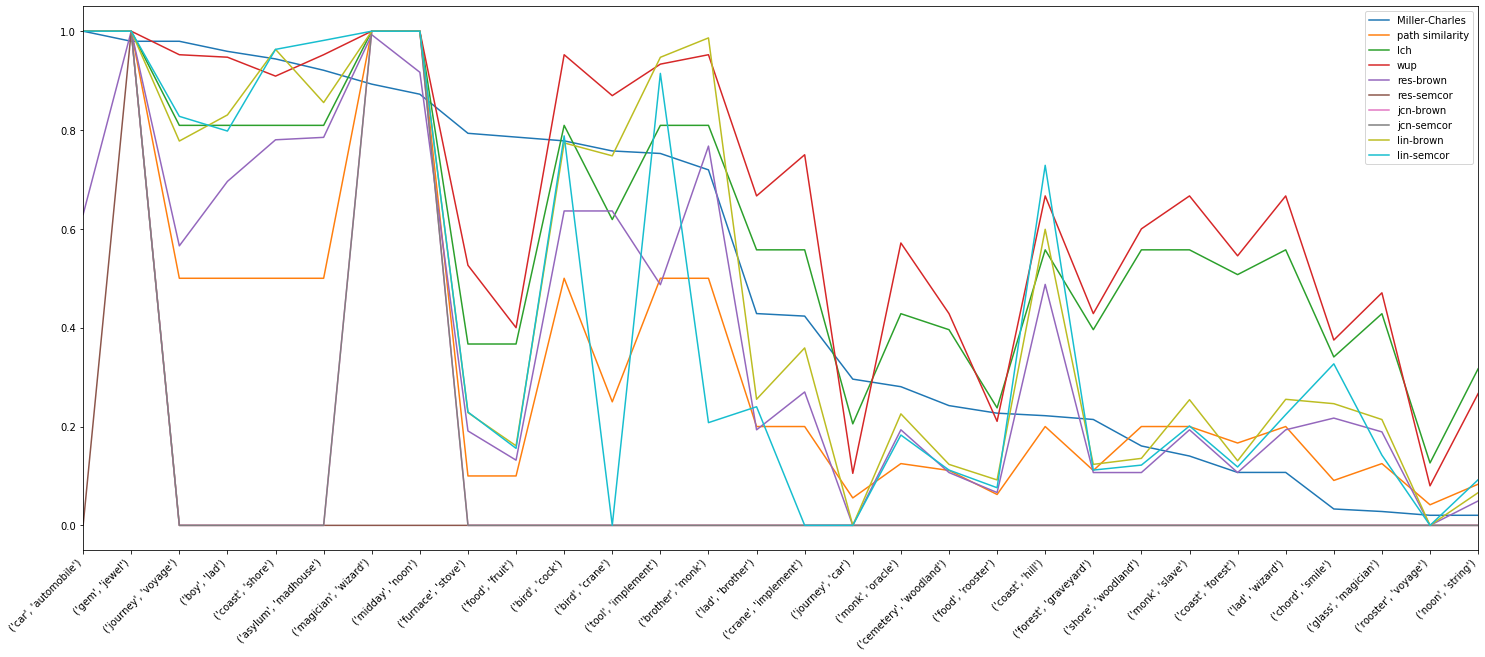

In [154]:
import matplotlib.pyplot as plt

ax = df_final.plot(figsize=(25, 10));
ax.set_xticks(df_final.index);
ax.set_xticklabels(df_final['pairs'], rotation = 45,  horizontalalignment = 'right');

*Right away I can see a problem: in some measures, there are a few values which are huge, whereas the rest are nearly zero.  Let's look at the merged dataframe to see if we can find which measures those are.*

In [155]:
df_final

,pairs,Miller-Charles,path similarity,lch,wup,res-brown,res-semcor,jcn-brown,jcn-semcor,lin-brown,lin-semcor
0,"(car, automobile)",1.000000,1.000000,1.000000,1.000000,0.629068,7.003586e-300,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
1,"(gem, jewel)",0.979592,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
2,"(journey, voyage)",0.979592,0.500000,0.809449,0.952381,0.565638,7.140787e-300,2.562806e-301,3.533885e-301,0.777715,8.276818e-01
3,"(boy, lad)",0.959184,0.500000,0.809449,0.947368,0.696031,6.741879e-300,2.917961e-301,2.928736e-301,0.830562,7.979405e-01
4,"(coast, shore)",0.943878,0.500000,0.809449,0.909091,0.780243,8.102198e-300,1.390583e-300,1.615407e-300,0.963217,9.632038e-01
5,"(asylum, madhouse)",0.920918,0.500000,0.809449,0.952381,0.785167,1.066715e-299,3.126296e-301,2.466303e-300,0.855584,9.813491e-01
6,"(magician, wizard)",0.892857,1.000000,1.000000,1.000000,0.992790,1.107261e-299,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
7,"(midday, noon)",0.872449,1.000000,1.000000,1.000000,0.916861,9.568535e-300,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
8,"(furnace, stove)",0.793367,0.100000,0.367002,0.526316,0.191076,2.493384e-300,6.409105e-302,5.969083e-302,0.228138,2.293847e-01
9,"(food, fruit)",0.785714,0.100000,0.367002,0.400000,0.131985,1.779817e-300,9.150387e-302,8.607225e-302,0.160984,1.558620e-01


*It looks like both the Jiang-Conrath Similarity measures and the Resnick Similarity measure with the SemCor IC file sometimes produce extremely large values, which presents problems when we normalize the range.  Although I'd prefer not to do this, I don't know enough about these measures' methodologies to discern why this is happening, so for the sake of simplicity I'm just going to remove their values from the plot.*

In [156]:
# deleting jcn_brown, jcn_semcor and res_semcor

from functools import reduce

dfs = [df_mc, df_path_sim, df_lch_sim, df_wup_sim, df_rb_sim,  
        df_lb_sim, df_ls_sim]

df_final = reduce(lambda left, right: pd.merge(left, right, on = 'pairs'), dfs)

df_final.columns = ['pairs', 'Miller-Charles', 'path similarity', 'lch', 'wup', 'res-brown', 
                    'lin-brown', 'lin-semcor']

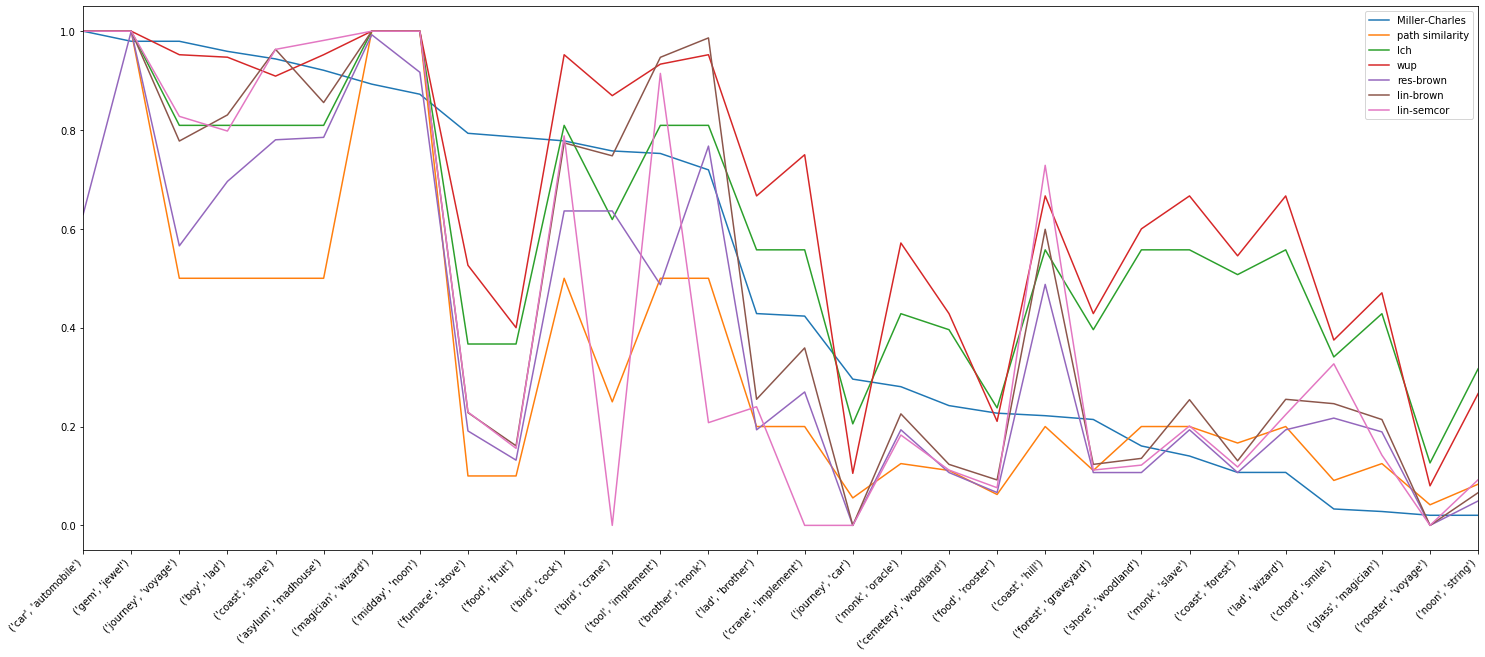

In [157]:
import matplotlib.pyplot as plt

ax = df_final.plot(figsize=(25, 10));
ax.set_xticks(df_final.index);
ax.set_xticklabels(df_final['pairs'], rotation = 45,  horizontalalignment = 'right');

*This plot is much easier to interpret. For the most part, the trends tend to agree, but there are a few outliers: noticeably, `('bird', 'crane')`, which has a much lower similarity score using Lin's Similarity with the SemCor IC files.  Also notice how in places (e.g. 'furnace-stove' and 'coast-hill') the similarity measures included with WordNet tend to agree with each other, but disagree with Miller & Charles.*